In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

import os
import numpy as np
import pandas as pd
import random

CONFIG

In [29]:
config = {
    # config for the neural network
    "nn": {
        "window": 50, # this is also the window, window size or entries used to predict the future price
        "nLayers": 2, # 2
        "neurons": 256, # 256
        "nFeatures": 5,
        "dropout": 0.3,
        "lossFunc": "huber_loss", # "huber_loss" Huber looss is better to give outliers some weight but not too much, which can be good for predicting asset prices?
        "optimizer": "adam", # "adam"
        "layerType": LSTM, # could set it upt to be a list of the layers that need to be generated [LSTM LSTM] 2 hidden layers 
    },
    "data": {
        "ticker": "TSLA", # "TSLA" "AMZN" "AAPL" "NVDA" "AMD"
        "offset": pd.DateOffset(years = 3, months = 0, days = 0),
        "lookahead": 2,
        "validation": 0.1, # percentage of training data to be used as validation
        "testSize": 0.1, # to test on 
        "scale": True,
        "scaler": preprocessing.MinMaxScaler(),
        "inputs": ['adjclose', 'volume', 'open', 'high', 'low'],
    },
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64, # 64
        "num_epoch": 100, # 500
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}
# DISPLAY AROUGH ESTIMATE OF HOW MANY DAYS WILL BE USED FOR EACH SECTION
damping = 0.9 # some extra damping for extra days that data isn't collected

offset = config["data"]["offset"]
ts1 = pd.Timestamp('2023-02-25')
ts2 = ts1 + offset
td = ts2 - ts1
days_offset = int(td.days/7*5*damping) # find out the roungh amount of days imported
print(f"{days_offset} Total days used will be roughly imported\n")
print(f"{days_offset* (1-config['data']['validation']-config['data']['testSize'])} Days used for training")
print(f"{days_offset*config['data']['validation']} Days used for validation")
print(f"{days_offset*config['data']['testSize']} Days used for testing")

704 Total days used will be roughly imported

563.2 Days used for training
70.4 Days used for validation
70.4 Days used for testing


Import all the required libraries for this proect
Keep in mind you have to install the following libraries first before this code can be run

pip install tensorflow pandas numpy matplotlib yahoo_fin scikit-learn

if the computer being used is an silicon apple chip then for tensorflow the following must be done

conda install -c apple tensorflow-deps
pip install tensorflow-macos
pip install tensorflow-metal # this is an optional but recommended

pip install pandas numpy matplotlib yahoo_fin scikit-learn

python -m pip install jupyter notebook -U

conda install -c conda-forge -y pandas jupyter


In [30]:
from tensorflow.keras import models
from tensorflow.keras.layers import Dropout, LSTM, Dense


"""
HERE mean_absolute_error CAN BE REPLACED BY mse?
Also need to have a look at bidirectional network and how that works and so forth

"""
def generateModel(
    window,
    n_layers=2,
    neurons=256,
    n_features=5,
    dropout=0.3,
    loss="mean_absolute_error",
    optimizer="rmsprop",
    layerType=LSTM
    ):
    # generate a keras model to linearly group a stasck of layers
    model = models.Sequential()
    # repeat for each layer
    for layer in range(n_layers):
        # check for first layer
        if layer == 0:
            """NEED TO FIGURE OUT THE DIFFERENE BETWEEN THEESE TWO LINES OF CODE, INPUT SHAPE AND BATCH INPUT SHAPE"""
            model.add(LSTM(neurons, return_sequences=True, input_shape=(window, n_features)))
            # model.add(layerType(neurons, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        # check for final layer
        elif layer == n_layers - 1:
            model.add(layerType(neurons, return_sequences=False))
        # middle/hidden layers
        else:
            model.add(layerType(neurons, return_sequences=True))

        # add dropout after each layer
        """ this layer helps prevent over fitting
        The Dropout layer randomly sets input units to 0
        with a frequency of rate at each step during training time,
        which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate)
        such that the sum over all inputs is unchanged."""
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    # compile the model once it has be compelted
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model


Generate the model by setting up all the parameters:

adjclose, volume, open, high and low as the 5 inputs of the model

In [31]:
# create a model using the options in CONFIG
model = generateModel(
    config["nn"]["window"],
    config["nn"]["nLayers"],
    config["nn"]["neurons"],
    n_features= config["nn"]["nFeatures"],
    dropout= config["nn"]["dropout"],
    loss= config["nn"]["lossFunc"],
    optimizer= config["nn"]["optimizer"],
    layerType= config["nn"]["layerType"]
    )

# display the model summary
model.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_128 (LSTM)             (None, 50, 256)           268288    
                                                                 
 dropout_128 (Dropout)       (None, 50, 256)           0         
                                                                 
 lstm_129 (LSTM)             (None, 256)               525312    
                                                                 
 dropout_129 (Dropout)       (None, 256)               0         
                                                                 
 dense_44 (Dense)            (None, 1)                 257       
                                                                 
Total params: 793,857
Trainable params: 793,857
Non-trainable params: 0
_________________________________________________________________


Visualisze the model

In [32]:
# import
from tensorflow.keras import models, layers, utils, backend as K 
import matplotlib.pyplot as plt
import numpy as np
'''
Extract info for each layer in a keras model.
'''
def utils_nn_config(model):
    lst_layers = []
    if "Sequential" in str(model): #-> Sequential doesn't show the input layer
        layer = model.layers[0]
        lst_layers.append({"name":"input", "in":int(layer.input.shape[-1]), "neurons":0, 
                           "out":int(layer.input.shape[-1]), "activation":None,
                           "params":0, "bias":0})
    for layer in model.layers:
        try:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":layer.units, 
                         "out":int(layer.output.shape[-1]), "activation":layer.get_config()["activation"],
                         "params":layer.get_weights()[0], "bias":layer.get_weights()[1]}
        except:
            dic_layer = {"name":layer.name, "in":int(layer.input.shape[-1]), "neurons":0, 
                         "out":int(layer.output.shape[-1]), "activation":None,
                         "params":0, "bias":0}
        lst_layers.append(dic_layer)
    return lst_layers

'''
Plot the structure of a keras neural network.
'''
def visualize_nn(model, description=False, figsize=(10,8)):
    ## get layers info
    lst_layers = utils_nn_config(model)
    layer_sizes = [layer["out"] for layer in lst_layers]
    
    ## fig setup
    fig = plt.figure(figsize=figsize)
    ax = fig.gca()
    ax.set(title=model.name)
    ax.axis('off')
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9
    x_space = (right-left) / float(len(layer_sizes)-1)
    y_space = (top-bottom) / float(max(layer_sizes))
    p = 0.025
    
    ## nodes
    for i,n in enumerate(layer_sizes):
        top_on_layer = y_space*(n-1)/2.0 + (top+bottom)/2.0
        layer = lst_layers[i]
        color = "green" if i in [0, len(layer_sizes)-1] else "blue"
        color = "red" if (layer['neurons'] == 0) and (i > 0) else color
        
        ### add description
        if (description is True):
            d = i if i == 0 else i-0.5
            if layer['activation'] is None:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
            else:
                plt.text(x=left+d*x_space, y=top, fontsize=10, color=color, s=layer["name"].upper())
                plt.text(x=left+d*x_space, y=top-p, fontsize=10, color=color, s=layer['activation']+" (")
                plt.text(x=left+d*x_space, y=top-2*p, fontsize=10, color=color, s="Σ"+str(layer['in'])+"[X*w]+b")
                out = " Y"  if i == len(layer_sizes)-1 else " out"
                plt.text(x=left+d*x_space, y=top-3*p, fontsize=10, color=color, s=") = "+str(layer['neurons'])+out)
        
        ### circles
        for m in range(n):
            color = "limegreen" if color == "green" else color
            # radius=y_space/4.0
            circle = plt.Circle(xy=(left+i*x_space, top_on_layer-m*y_space-4*p), radius=y_space/10, color=color, ec='k', zorder=4)
            ax.add_artist(circle)
            
            ### add text
            if i == 0:
                plt.text(x=left-4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$X_{'+str(m+1)+'}$')
            elif i == len(layer_sizes)-1:
                plt.text(x=right+4*p, y=top_on_layer-m*y_space-4*p, fontsize=10, s=r'$y_{'+str(m+1)+'}$')
            else:
                plt.text(x=left+i*x_space+p, y=top_on_layer-m*y_space+(y_space/8.+0.01*y_space)-4*p, fontsize=10, s=r'$H_{'+str(m+1)+'}$')
    
    ## links
    for i, (n_a, n_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer = lst_layers[i+1]
        color = "green" if i == len(layer_sizes)-2 else "blue"
        color = "red" if layer['neurons'] == 0 else color
        layer_top_a = y_space*(n_a-1)/2. + (top+bottom)/2. -4*p
        layer_top_b = y_space*(n_b-1)/2. + (top+bottom)/2. -4*p
        for m in range(n_a):
            for o in range(n_b):
                line = plt.Line2D([i*x_space+left, (i+1)*x_space+left], 
                                  [layer_top_a-m*y_space, layer_top_b-o*y_space], 
                                  c=color, alpha=0.5)
                if layer['activation'] is None:
                    if o == m:
                        ax.add_artist(line)
                else:
                    ax.add_artist(line)
    plt.show()

# visualize_nn(model, description=True, figsize=(10,8)) # 10 by 8

Importing the data to be used with the neural netowork

"get_data" from "stock_info" takes the arguments:
- ticker: case insensitive ticker of the desired stock/bond
- start_date: date you want the data to start from (mm/dd/yyyy)
- end_date: date you want the data to end (mm/dd/yyyy)
- index_as_date: {True, False}. Default is true. If true then the dates of the records are set as the index, else they are returned as a separate column.
- interval: {“1d”, “1wk”, “1mo”}. Refers to the interval to sample the data: “1d”= daily, “1wk”= weekly, “1mo”=monthly.

DATA LOADER

In [49]:
# Import yfinance package (NEED OT DOUBLE CHEKC IF THIS IS ACTUALLY A MODEL THAT CAN BE USED)

# import yfinance as yf # make sure to unisntall if this isn't used in the future
from yahoo_fin import stock_info
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn import preprocessing

from collections import deque

def getData(
    ticker,
    offset
    ):
    # setup the start date and end date
    startDate = (datetime.now() - offset).date()
    endDate = datetime.now().date()
    # Get the data
    stocks = stock_info.get_data(ticker, startDate, endDate)
    # display how many days of data are being used for this
    print(f"{ticker} data has been imported between {startDate} and the {endDate}, for a total of {len(stocks)} days of data")
    # print(f"Each day contains the prices for: {stocks.columns}")
    return stocks

def setupData(
    stocks, # data to be reshaped
    window = 50, # the number of days used to predic the next value (window size or lookback perdiod)
    predAhead = 10, # the number of days ahead that you are tyring to predict
    validationSize = 0.1, # amount of data out of the training data to be used as validation
    testSize = 0.2, # the amount of data that will be  used for testing e.g. 0.2 -> 20%
    scale = True, # minmaxscaler
    scaler = preprocessing.MinMaxScaler(), # the scaler to be used
    inputs = ['adjclose', 'volume', 'open', 'high', 'low']
    ):
    # Setup a dictionary to store all the data
    data = {}
    # copy the data frame
    data["raw"] = stocks.copy()

    """This is something that really needs to be fixed in the future"""
    # I HAVE TO COPY THE STOCKS SO THAT THE ORIGINAL ONES AREN'T RETURNED? WHAT IS THIS ABOUT
    stocks = stocks.copy()
    



    # should we scale down between 0 and 1? It can make analysis easier
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in inputs:
            # scale the columns
            stocks[column] = scaler.fit_transform(np.expand_dims(stocks[column].values, axis=1))
            column_scaler[column] = scaler
        # add the MinMaxScaler instances to the result returned
        data["column_scaler"] = column_scaler

    # create input a variable with x and y
    x = []
    y = []
    ydates = []
    for i in range(len(stocks)-window-predAhead+1):
        x.append(np.array(stocks[inputs].values[i:i+window]))
        y.append(stocks["adjclose"].values[i+window+predAhead-1])
        ydates.append(stocks.index[i+window+1])
    # convert into numpy arrays
    x = np.array(x)
    y = np.array(y)

    # store x and y into the data dictionary
    data["x"] = x
    data["y"] = y
    data["ydates"] =  ydates

    # split the dataset into training & testing sets by date
    # make sure to convert to an integer so that it can be used for indexing
    trainSamples = int((1 - testSize - validationSize) * len(x))
    valSamples = int(validationSize * len(x))
    data["xtrain"] = x[:trainSamples]
    data["ytrain"] = y[:trainSamples]

    data["xval"] = x[trainSamples:trainSamples+valSamples]
    data["yval"] = y[trainSamples:trainSamples+valSamples]

    data["xtest"]  = x[trainSamples+valSamples:]
    data["ytest"]  = y[trainSamples+valSamples:]
    
    data["trainDates"] = ydates[:trainSamples]
    data["valDates"] = ydates[trainSamples:trainSamples+valSamples]
    data["testDates"] = ydates[trainSamples+valSamples:]

    return data

In [34]:
# download data form yt
stocks = getData(config["data"]["ticker"], config["data"]["offset"])
stocks.keys()

Data is imported between 2020-02-27 and the 2023-02-27, for a total of 755 days of data
Each day contains the prices for: Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')


Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')

In [35]:
# process the data
data = setupData(stocks, config["nn"]["window"], config["data"]["lookahead"], config["data"]["validation"], config["data"]["testSize"], config["data"]["scale"], config["data"]["scaler"], config["data"]["inputs"])
data.keys()

print(f"{data.keys()}\n\nHere are the adjusted values downloaded:")

print(data.keys())

print(len(data["raw"]))
print(len(data["ydates"]))


dict_keys(['raw', 'column_scaler', 'x', 'y', 'ydates', 'xtrain', 'ytrain', 'xval', 'yval', 'xtest', 'ytest', 'trainDates', 'valDates', 'testDates'])

Here are the adjusted values downloaded:
dict_keys(['raw', 'column_scaler', 'x', 'y', 'ydates', 'xtrain', 'ytrain', 'xval', 'yval', 'xtest', 'ytest', 'trainDates', 'valDates', 'testDates'])
755
704


Plot the data imported form the stocks

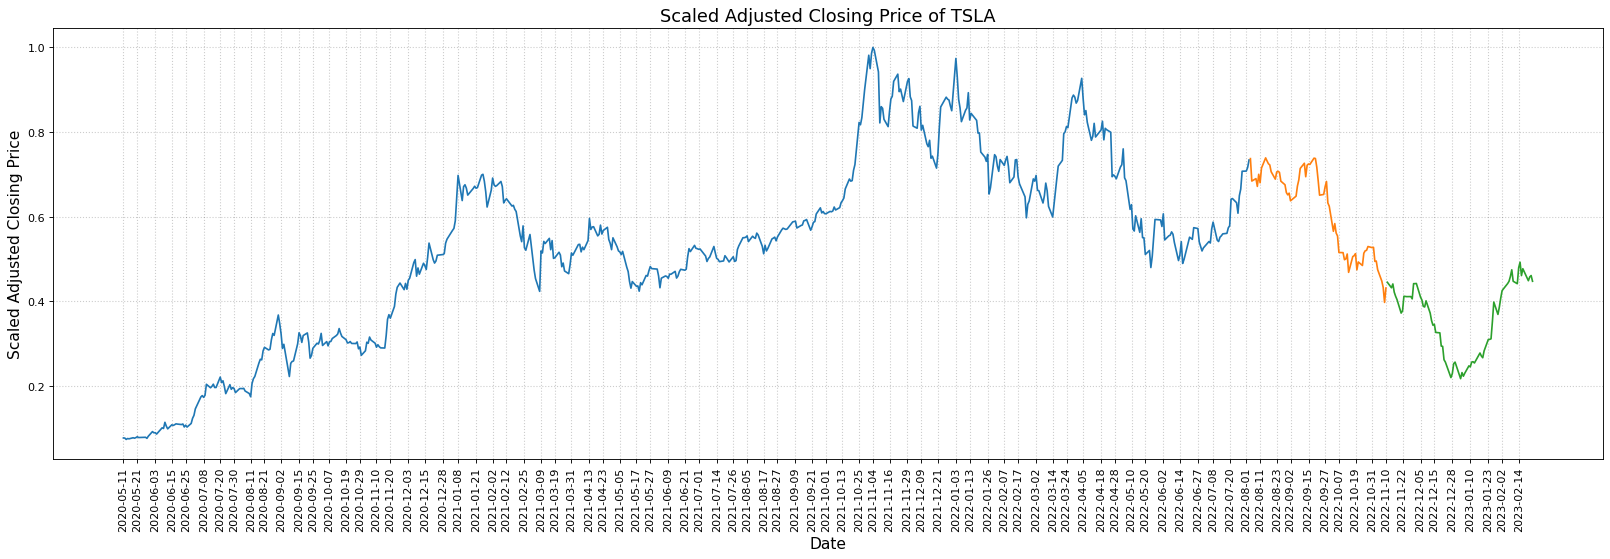

In [36]:
import matplotlib.pyplot as plt

plots = "trainDates ytrain,valDates yval,testDates ytest"
lines = 100
fig = plt.figure(figsize=(25, 7), dpi=80)
# plot all the different lines
for plot in plots.split(","):
    x, y = plot.split()
    plt.plot(data[f"{x}"], data[f"{y}"])
step = round(len(data["raw"]["adjclose"].keys())/lines)
plt.xticks(data["ydates"][::step], rotation='vertical') 
# Plot the grid lines
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
scaled = lambda x: "Scaled " if x == True else None
plt.title(f"{scaled(config['data']['scale'])}Adjusted Closing Price of {config['data']['ticker']}", fontsize=16)
# Define the labels for x-axis and y-axis
plt.ylabel(f"{scaled(config['data']['scale'])}Adjusted Closing Price", fontsize=14)
plt.xlabel("Date", fontsize=14)
# show the plot
plt.show()


Train the model

pip install tensorflow-macos==2.10
pip install tensorflow-metal==0.6

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

model_name = "trials"

checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

# Train the model by using the funciton fit
model.fit(data["xtrain"], data["ytrain"],
                    batch_size=config["training"]["batch_size"],
                    epochs=config["training"]["num_epoch"],
                    validation_data=(data["xval"], data["yval"]),
                    verbose=1) # should be able to chance verbose to 100 to display every 100 but doesn't seem to work
                    # callbacks=[checkpointer, tensorboard],


Epoch 1/100


2023-02-27 19:31:50.924346: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-27 19:31:52.314093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:31:52.540063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:31:52.701702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:31:52.905962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:31:53.101501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0474 - mean_absolute_error: 0.2371

2023-02-27 19:31:54.409420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:31:54.490735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:31:54.583800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 4s 196ms/step - loss: 0.0474 - mean_absolute_error: 0.2371 - val_loss: 0.0084 - val_mean_absolute_error: 0.1157
Epoch 2/100
9/9 [==============================] - 0s 43ms/step - loss: 0.0058 - mean_absolute_error: 0.0843 - val_loss: 0.0029 - val_mean_absolute_error: 0.0652
Epoch 3/100
9/9 [==============================] - 0s 43ms/step - loss: 0.0035 - mean_absolute_error: 0.0631 - val_loss: 0.0027 - val_mean_absolute_error: 0.0585
Epoch 4/100
9/9 [==============================] - 0s 41ms/step - loss: 0.0027 - mean_absolute_error: 0.0545 - val_loss: 0.0017 - val_mean_absolute_error: 0.0486
Epoch 5/100
9/9 [==============================] - 0s 50ms/step - loss: 0.0022 - mean_absolute_error: 0.0465 - val_loss: 0.0020 - val_mean_absolute_error: 0.0498
Epoch 6/100
9/9 [==============================] - 0s 42ms/step - loss: 0.0016 - mean_absolute_error: 0.0417 - val_loss: 0.0014 - val_mean_absolute_error: 0.0439
Epoch 7/100
9/9 [======================

Plot the results

2023-02-27 19:32:34.894567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:32:34.963098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 19:32:35.059564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 80ms/step


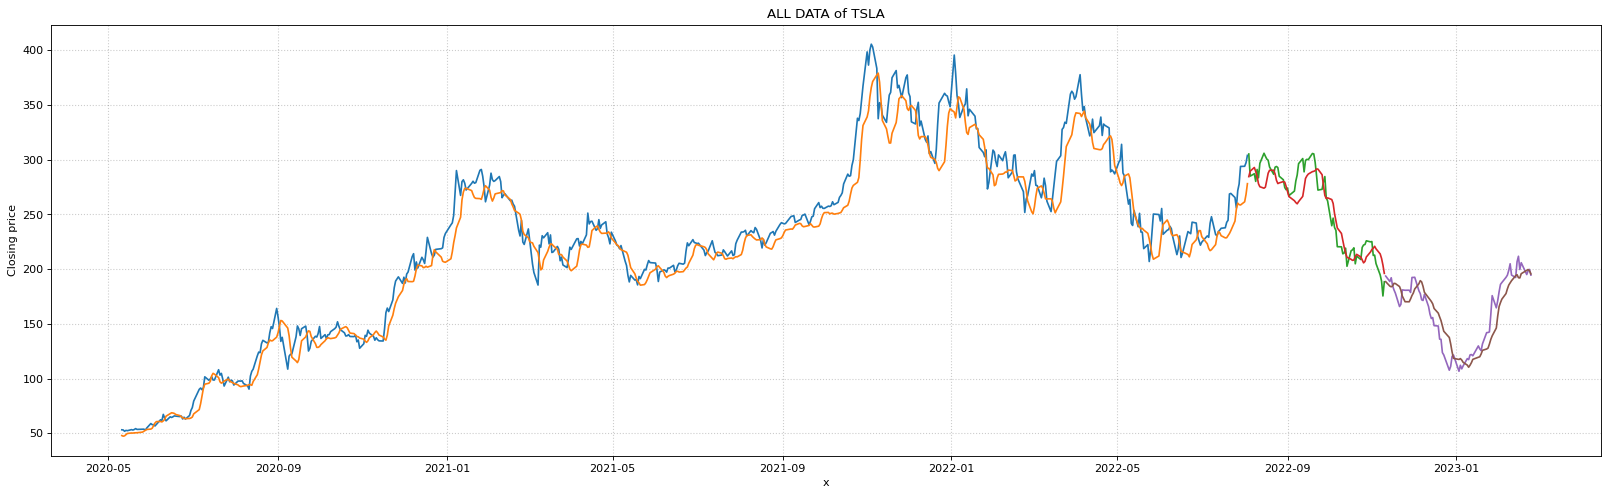

In [38]:
# for the training
pred_ytrain = model.predict(data["xtrain"])
ytrain = data["ytrain"]
# scaler = config["data"]["scaler"]
pred_ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytrain))
ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytrain, axis=0)))


# for the training
pred_yval = model.predict(data["xval"])
yval = data["yval"]
# scaler = config["data"]["scaler"]
pred_yval = np.squeeze(config["data"]["scaler"].inverse_transform(pred_yval))
yval = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(yval, axis=0)))


# for the training
pred_ytest = model.predict(data["xtest"])
ytest = data["ytest"]
# scaler = config["data"]["scaler"]
pred_ytest = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytest))
ytest = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytest, axis=0)))





# plot the results
# # TRAINING DATA
# fig= plt.figure(figsize=(25, 7), dpi=80)
# plt.plot(ytrain)
# plt.plot(pred_ytrain)
# plt.title(f"Training data of {config['data']['ticker']}")
# plt.xlabel("x")
# plt.ylabel("Closing price")
# xticks = 100
# step = round(len(data["raw"]["adjclose"].keys())/xticks)
# plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
# plt.legend("Actual,Neural Network".split(","))
# plt.show()
# # VALIDATION DATA
# fig= plt.figure(figsize=(25, 7), dpi=80)
# plt.plot(yval, "*-") # actual data
# plt.plot(pred_yval, "*-")
# plt.title(f"Validation data of {config['data']['ticker']}")
# plt.xlabel("x")
# plt.ylabel("Closing price")
# xticks = 100
# step = round(len(data["raw"]["adjclose"].keys())/xticks)
# plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
# plt.show()
# ALL 3 TOGETHER
# plot the results
fig= plt.figure(figsize=(25, 7), dpi=80)
# for the training
plt.plot(data["trainDates"],ytrain) # train data
plt.plot(data["trainDates"], pred_ytrain)
plt.plot(data["valDates"], yval) # val data
plt.plot(data["valDates"], pred_yval)
plt.plot(data["testDates"], ytest) # test data
plt.plot(data["testDates"], pred_ytest)
plt.title(f"ALL DATA of {config['data']['ticker']}")
plt.xlabel("x")
plt.ylabel("Closing price")
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.show()



Other methods to compare against

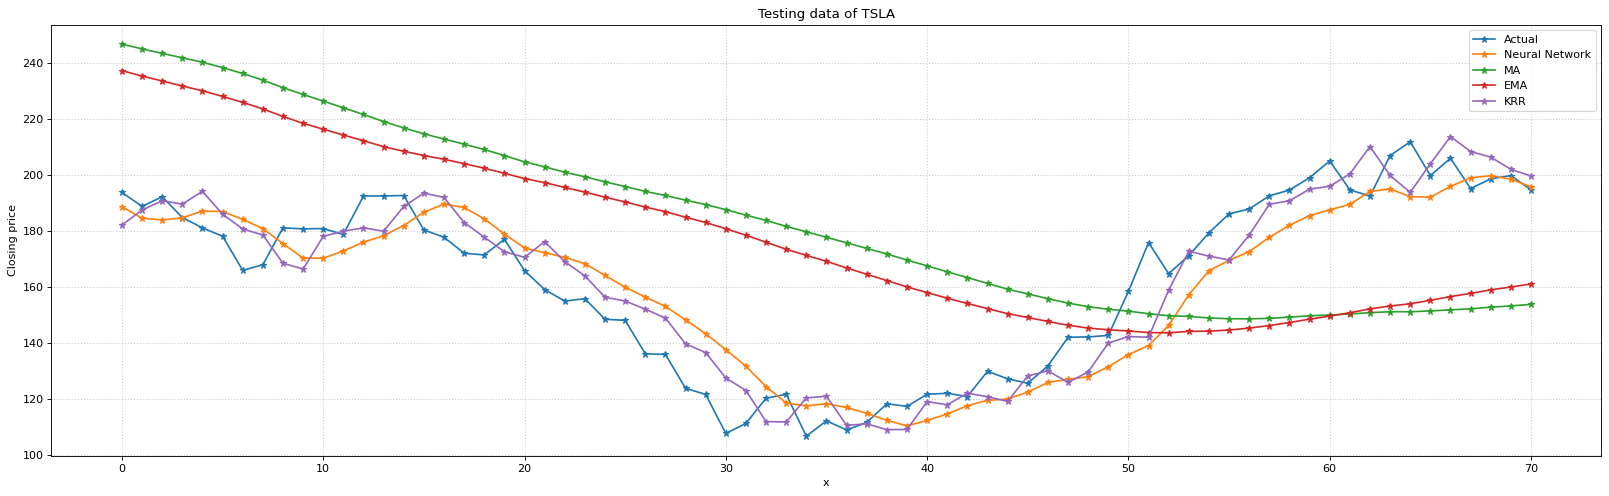

In [39]:
# TEST DATA

# Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge
krr = KernelRidge(alpha=0.1, kernel='rbf') # why is rbf been used here? and what does the alpha control
# Train the model on the training data
krr.fit(data['xtrain'][:, -1, :], data['ytrain'])
# Make predictions on the test data
pred_krr = krr.predict(data['xtest'][:, -1, :])
pred_krr = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_krr, axis=0)))


# calcualte the price using a simple moving average
pred_ma = np.mean(data["xtest"], axis = 1)
pred_ma = pred_ma[:, 0] # take only the adjclose price out
pred_ma = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ma, axis=0)))

# calculate the price using exponential moving average
pred_ema = data["xtest"][:, :, 0] # only take the 
# pred_EMA = np.squeeze(config["data"]["scaler"].inverse_transform(pred_EMA))
weights = np.exp(np.linspace(-1, 0, config["nn"]["window"]))
weights /= weights.sum()
pred_ema = pred_ema@weights
pred_ema = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ema, axis=0)))

# plot the results
fig= plt.figure(figsize=(25, 7), dpi=80)
plt.plot(ytest, "*-") # actual data
plt.plot(pred_ytest, "*-") # prediction made by neural network
plt.plot(pred_ma, "*-")
plt.plot(pred_ema, "*-")
plt.plot(pred_krr, "*-")
plt.title(f"Testing data of {config['data']['ticker']}")
plt.xlabel("x")
plt.ylabel("Closing price")
xticks = 100
step = round(len(data["raw"]["adjclose"].keys())/xticks)
plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
plt.legend("Actual,Neural Network,MA,EMA,KRR".split(","))
plt.show()

 RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error %) will be our current model evaluation metrics. Both are useful measures of forecast accuracy. 

In [40]:
# Mean Squared Error
calc_mse = lambda y_true, y_pred: np.mean((y_true-y_pred)**2)
# Root Mean Squared Error
calc_rmse = lambda y_true, y_pred: np.sqrt(np.mean((y_true-y_pred)**2))
# Mean Absolute Error
calc_mae = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))
# Mean Absolute Percentage Error
calc_mape = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))*100
# Directional accuracy
calc_da = lambda y_true, y_pred: np.mean([(y_true[i+1]-y_true[i])*(y_pred[i+1]-y_pred[i]) > 0 for i in range(len(y_true)-1)])
# def calc_da(y_true, y_pred):
#     count = 0
#     predictions = len(y_true)-1
#     for i in range(predictions):
#         true_dir = y_true[i+1]-y_true[i]
#         pred_dir = y_pred[i+1]-y_pred[i]

#         # if true_dir > 0 and pred_dir > 0 or true_dir <= 0 and pred_dir <= 0:
#         if true_dir * pred_dir > 0:
#             count += 1
#         # print(true_grad/abs(true_grad))
#     return count/predictions
# Coefficient of determination R²
calc_cod = lambda y_true, y_pred: 1 - (sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2))

# compare all the following data
pairs = [[ytrain, pred_ytrain, 'Training NN'],
         [yval, pred_yval, 'Validation NN'],
         [ytest, pred_ytest, 'Testing NN'],
         [ytest, pred_krr, 'Testing KRR'],
         [ytest, pred_ma, 'Testing MA'],
         [ytest, pred_ema, 'Testing EMA']
         ]

d = {}
for pair in pairs:
    d[pair[2]] = []
    d[pair[2]].append(calc_mse(pair[0], pair[1]))
    d[pair[2]].append(calc_rmse(pair[0], pair[1]))
    # d[pair[2]].append(calc_mae(pair[0], pair[1]))
    d[pair[2]].append(calc_mape(pair[0], pair[1]))
    d[pair[2]].append(calc_da(pair[0], pair[1]))
    d[pair[2]].append(calc_cod(pair[0], pair[1]))

df = pd.DataFrame(data=d)
df.index = ['MSE', 'RMSE', 'MAPE', 'DA', 'R²']
df

Training NN  Validation NN  Testing NN  Testing KRR   Testing MA  \
MSE    295.007437     212.245888  172.759693   117.299685  2316.624984   
RMSE    17.175781      14.568661   13.143808    10.830498    48.131331   
MAPE     5.448532       4.751548    7.227501     5.835578    29.803178   
DA       0.482206       0.463768    0.628571     0.542857     0.514286   
R²       0.956515       0.854657    0.824787     0.881034    -1.349525   

      Testing EMA  
MSE   1798.903505  
RMSE    42.413483  
MAPE    25.905475  
DA       0.585714  
R²      -0.824451

Trading stocks

Neural Netowrk         KRR Moving Average Exp Moving Average
Percentage                70.73%       2.14%         10.17%              0.00%
Buy in                £ 1,000.00  £ 1,000.00     £ 1,000.00         £ 1,000.00
Cash out              £ 1,707.28  £ 1,021.45     £ 1,101.70         £ 1,000.00
14.0 weeks profit       £ 707.28     £ 21.45       £ 101.70             £ 0.00
Profit per month        £ 307.53      £ 9.33        £ 44.22             £ 0.00

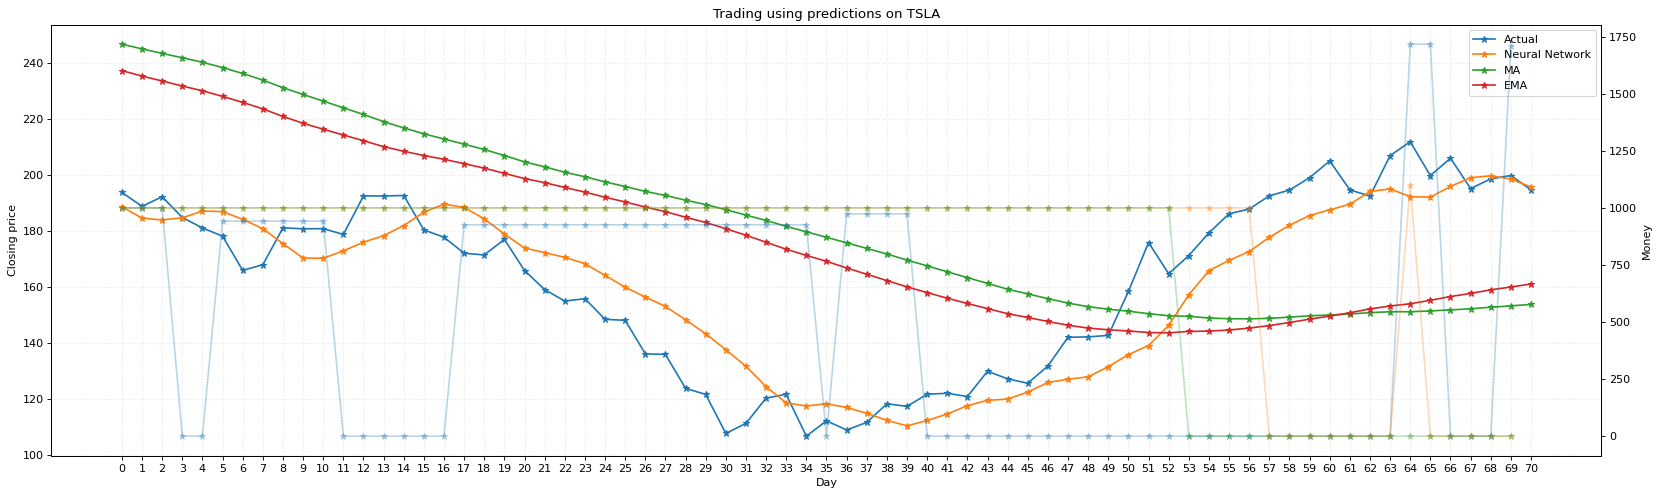

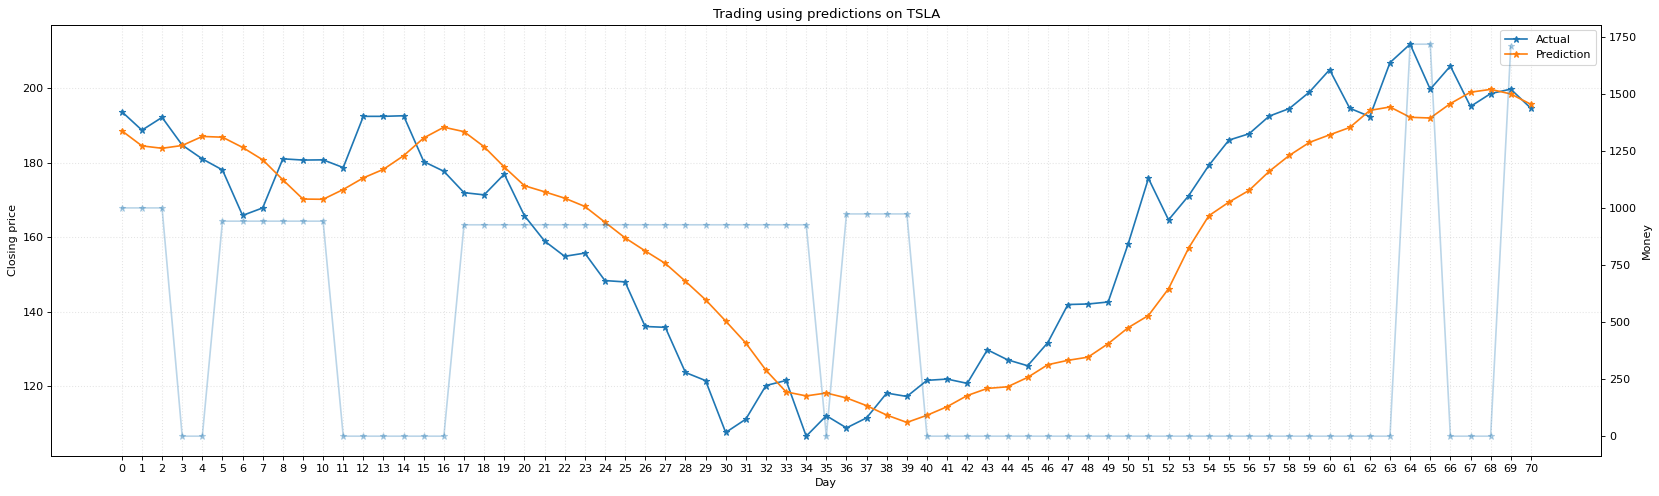

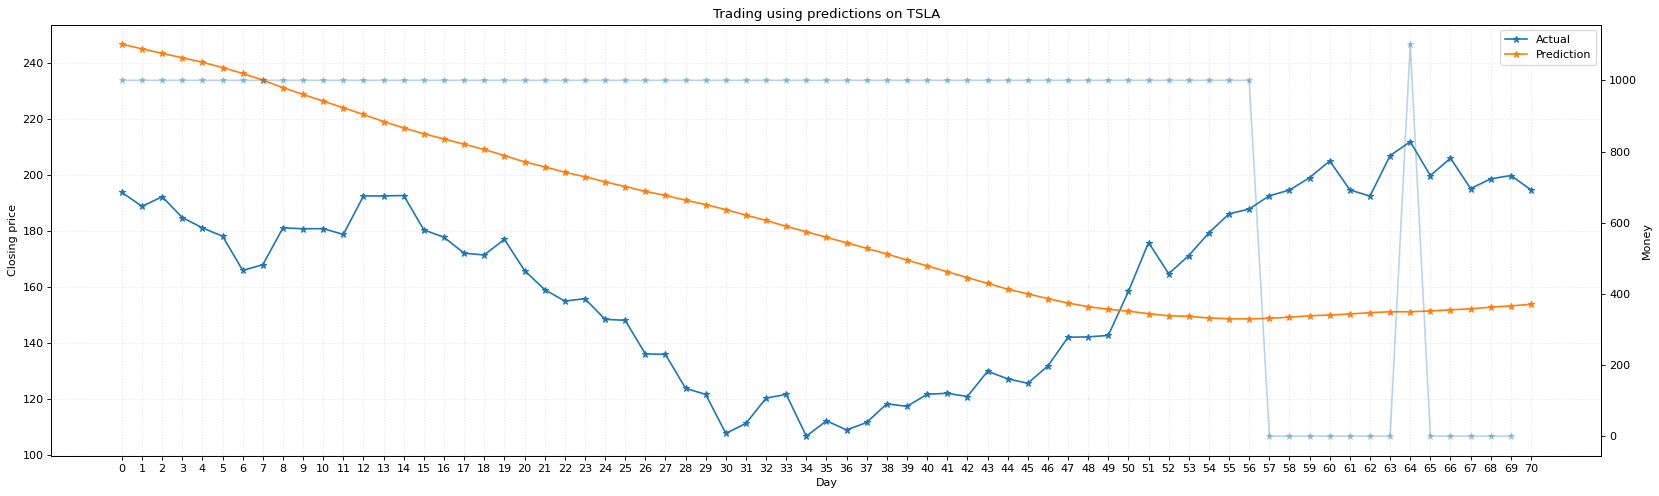

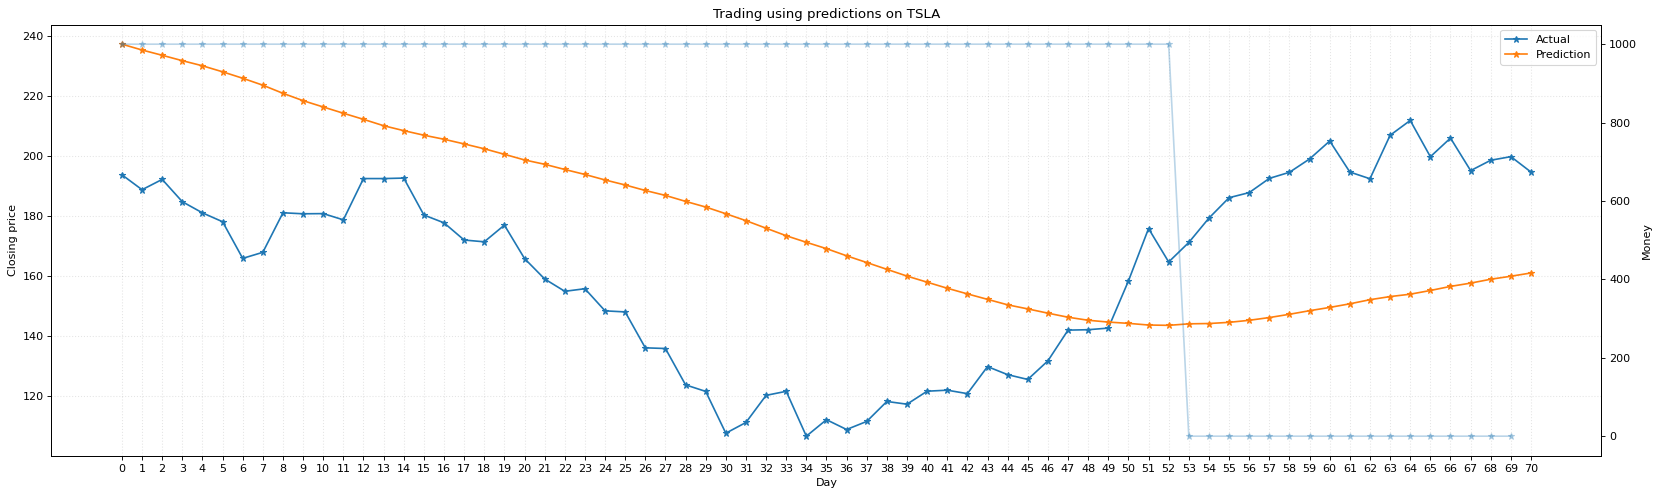

In [41]:
def trader(money, actual, predictions):
    owned_shares = 0
    history = [money]
    
    for i in range(len(predictions)-2):
        # keep track of what is owned
        history.append(money)

        # find out the prices
        # prev_price, curr_price, next_price = actual[i], actual[i+1], predictions[i+2]
        prev_price, curr_price, next_price = predictions[i], predictions[i+1], predictions[i+2]
        # buy
        if prev_price > curr_price and next_price > curr_price:
            if money == 0:
                # print(f"Can't buy {money, owned_shares}")
                continue
            # work out how many shares it buys
            owned_shares = money/actual[i+1]
            money = 0
            # print(f'buy {money, owned_shares}')
        # sell
        elif prev_price < curr_price and next_price < curr_price:
            if owned_shares == 0:
                # print(f"Can't sell {money, owned_shares}")
                continue
            money = owned_shares*actual[i+1]
            owned_shares = 0
            # print(f'sell {money, owned_shares}')
        # hold
        else:
            # print('do nothing')
            continue
    
    return history

def calc_profit(money_history, initial_money):
    # find the last value that wasn't 0
    for i in reversed(range(len(money_history))):
        if money_history[i] != 0:
            # the final value of money
            break # money_history[i] is the final value that isn't 0
    money_made = money_history[i]-initial_money
    percentage = money_made/initial_money*100
    spacing = 0
    spacer = "."
    stats = [f"{percentage:.2f}%".rjust(spacing, spacer),
         f"£ {initial_money:,.2f}".rjust(spacing, spacer),
         f"£ {money_history[i]:,.2f}".rjust(spacing, spacer),
         f"£ {money_made:,.2f}".rjust(spacing, spacer),
         f"£ {money_made/(len(money_history)/30.437):,.2f}".rjust(spacing, spacer)]
    return stats

# plot the trades
def plot_trades(base, plots, alpha = 0.3, hold_on = 1):
    if hold_on:
        # plot the results
        fig, ax1 = plt.subplots(figsize=(25, 7), dpi=80)
        ax1.plot(base, "*-") # actual data
        ax2 = ax1.twinx()
        for plot in plots:
            ax1.plot(plot[0], "*-") # prediction
            ax2.plot(plot[1], "*-", alpha = alpha) # money over time
        ax1.legend("Actual,Neural Network,MA,EMA".split(","))
        ax1.set_ylabel("Closing price")
        # create a second axis
        ax2.set_ylabel("Money")
        # other plotting options
        ax1.set_xlabel("Day")
        plt.xticks(range(len(ytest)))
        ax1.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.1)
        plt.title(f"Trading using predictions on {config['data']['ticker']}")
        plt.show()
    # if not then create a different plot for each data set
    for plot in plots:
        # plot the results
        fig, ax1 = plt.subplots(figsize=(25, 7), dpi=80)
        ax1.plot(base, "*-") # actual data
        ax2 = ax1.twinx()
        ax1.plot(plot[0], "*-") # prediction
        ax2.plot(plot[1], "*-", alpha = alpha) # money over time
        ax1.legend("Actual,Prediction".split(","))
        ax1.set_ylabel("Closing price")
        # create a second axis
        ax2.set_ylabel("Money")
        # other plotting options
        ax1.set_xlabel("Day")
        plt.xticks(range(len(ytest)))
        ax1.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.1)
        plt.title(f"Trading using predictions on {config['data']['ticker']}")
        plt.show()
# initial, final = 40, -1
# ytest = ytest[initial:final]
# pred_ytest = pred_ytest[initial:final]
# pred_MA = pred_MA[initial:final]
# pred_EMA = pred_EMA[initial:final]

initial_money = 1000
nn_money = trader(initial_money, ytest, pred_ytest)
ma_money = trader(initial_money, ytest, pred_ma)
ema_money = trader(initial_money, ytest, pred_ema)
krr_money = trader(initial_money, ytest, pred_krr)
# calcualte and display the results of the trader
d = {"Neural Netowrk": calc_profit(nn_money, initial_money),
     "KRR": calc_profit(krr_money, initial_money),
     "Moving Average": calc_profit(ma_money, initial_money),
     "Exp Moving Average": calc_profit(ema_money, initial_money)
     }
df = pd.DataFrame(d, index = ['Percentage', 'Buy in', 'Cash out', f"{len(nn_money)/5} weeks profit", 'Profit per month'])
display(df) # display the dataframe

to_plot = [[pred_ytest, nn_money],
           [pred_ma, ma_money],
           [pred_ema, ema_money]
           ]
# plot the trading results
plot_trades(ytest, to_plot, 0.3, 1)


TESTS with different parameters

In [270]:
# Dataset settings
windows = [10, 50]
tickers = "TSLA,AMZN,AAPL,NVDA,AMD".split(",") #"TSLA,AMZN,AAPL,NVDA,AMD".split(",")
lookaheads = [2]
validations = [0.1]
tests = [0.1]
scaled = [True]

# Comparison options
epochs = [10, 100]
layers = [2]
num_neurons = [256]
dropouts = [0.3]
loss_functions = ["huber_loss"]
optimizers = ["adam"]
batch_sizes = [64]


import itertools
# download all the different data
stocks = {}
for ticker in tickers:
    print(ticker)
    stocks[ticker] = getData(ticker, config["data"]["offset"])
print()

# prepare data to be used for the different 
datasets = {}
for opts in itertools.product(tickers, windows, lookaheads, validations, tests, scaled):
    # print(opts)
    # process the data with all of the settings
    datasets[opts] = setupData(stocks[opts[0]], opts[1], opts[2], opts[3], opts[4], opts[5], config["data"]["scaler"], config["data"]["inputs"])
    # datasets[opts] = 1024
print()

# setup different models
combinations = [] # setup a list with all the differnet networks
for dataset in datasets:
    # create all the different networks
    print(dataset, dataset[1])
    nets = {}
    for opts in itertools.product(epochs, layers, num_neurons, dropouts, loss_functions, optimizers, batch_sizes):
        print(opts, opts[0])
        # create a model (window, number_of_layers, neurons, ...)
        model = generateModel(dataset[1], opts[1], opts[2], n_features= config["nn"]["nFeatures"], dropout= opts[3], loss= opts[4], optimizer= opts[5], layerType= config["nn"]["layerType"])
        # train the model on the dataset
        model.fit(datasets[dataset]["xtrain"], datasets[dataset]["ytrain"], batch_size= opts[6], epochs= opts[0], validation_data=(datasets[dataset]["xval"], datasets[dataset]["yval"]), verbose=1)
        # save the model
        nets[opts] = model
    # store all the trained networks and their dataest in a dictionary
    comb = {}
    comb["dataset"] = dataset # only save the name of the dataset used (it can be called from datasets at any point)
    comb["networks"] = nets
    # add the combination to the combinations
    combinations.append(comb)
    

TSLA
TSLA data has been imported between 2020-02-28 and the 2023-02-28, for a total of 755 days of data
AMZN
AMZN data has been imported between 2020-02-28 and the 2023-02-28, for a total of 755 days of data
AAPL
AAPL data has been imported between 2020-02-28 and the 2023-02-28, for a total of 755 days of data
NVDA
NVDA data has been imported between 2020-02-28 and the 2023-02-28, for a total of 755 days of data
AMD
AMD data has been imported between 2020-02-28 and the 2023-02-28, for a total of 755 days of data


('TSLA', 10, 2, 0.1, 0.1, True) 10
(10, 2, 256, 0.3, 'huber_loss', 'adam', 64) 10
Epoch 1/10


2023-02-28 02:34:54.263211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:34:54.541324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:34:54.812213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:34:55.285863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:34:55.606542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 0.1818

2023-02-28 02:34:57.779708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:34:57.872065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:34:58.025682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 289ms/step - loss: 0.0301 - mean_absolute_error: 0.1818 - val_loss: 0.0098 - val_mean_absolute_error: 0.1284
Epoch 2/10
10/10 [==============================] - 1s 80ms/step - loss: 0.0044 - mean_absolute_error: 0.0738 - val_loss: 0.0028 - val_mean_absolute_error: 0.0633
Epoch 3/10
10/10 [==============================] - 0s 37ms/step - loss: 0.0032 - mean_absolute_error: 0.0583 - val_loss: 0.0035 - val_mean_absolute_error: 0.0696
Epoch 4/10
10/10 [==============================] - 1s 76ms/step - loss: 0.0022 - mean_absolute_error: 0.0493 - val_loss: 0.0014 - val_mean_absolute_error: 0.0436
Epoch 5/10
10/10 [==============================] - 0s 37ms/step - loss: 0.0016 - mean_absolute_error: 0.0423 - val_loss: 0.0016 - val_mean_absolute_error: 0.0461
Epoch 6/10
10/10 [==============================] - 0s 32ms/step - loss: 0.0016 - mean_absolute_error: 0.0403 - val_loss: 0.0013 - val_mean_absolute_error: 0.0423
Epoch 7/10
10/10 [==============

2023-02-28 02:35:04.083545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:04.345177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:04.547251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:04.971437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:05.310071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.1845

2023-02-28 02:35:07.533737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:07.630892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:07.766262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 6s 291ms/step - loss: 0.0314 - mean_absolute_error: 0.1845 - val_loss: 0.0083 - val_mean_absolute_error: 0.1165
Epoch 2/100
10/10 [==============================] - 1s 58ms/step - loss: 0.0040 - mean_absolute_error: 0.0699 - val_loss: 0.0018 - val_mean_absolute_error: 0.0494
Epoch 3/100
10/10 [==============================] - 1s 57ms/step - loss: 0.0030 - mean_absolute_error: 0.0557 - val_loss: 0.0027 - val_mean_absolute_error: 0.0605
Epoch 4/100
10/10 [==============================] - 0s 40ms/step - loss: 0.0019 - mean_absolute_error: 0.0456 - val_loss: 0.0014 - val_mean_absolute_error: 0.0429
Epoch 5/100
10/10 [==============================] - 0s 31ms/step - loss: 0.0016 - mean_absolute_error: 0.0412 - val_loss: 0.0013 - val_mean_absolute_error: 0.0426
Epoch 6/100
10/10 [==============================] - 0s 45ms/step - loss: 0.0014 - mean_absolute_error: 0.0383 - val_loss: 0.0014 - val_mean_absolute_error: 0.0430
Epoch 7/100
10/10 [========

2023-02-28 02:35:36.385223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:36.599255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:36.871652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:37.332119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:37.681704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0368 - mean_absolute_error: 0.1975

2023-02-28 02:35:40.074851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:40.166991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:40.348553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 7s 359ms/step - loss: 0.0368 - mean_absolute_error: 0.1975 - val_loss: 0.0017 - val_mean_absolute_error: 0.0468
Epoch 2/10
9/9 [==============================] - 1s 75ms/step - loss: 0.0053 - mean_absolute_error: 0.0810 - val_loss: 0.0047 - val_mean_absolute_error: 0.0824
Epoch 3/10
9/9 [==============================] - 1s 71ms/step - loss: 0.0044 - mean_absolute_error: 0.0713 - val_loss: 0.0044 - val_mean_absolute_error: 0.0796
Epoch 4/10
9/9 [==============================] - 0s 53ms/step - loss: 0.0023 - mean_absolute_error: 0.0509 - val_loss: 0.0013 - val_mean_absolute_error: 0.0422
Epoch 5/10
9/9 [==============================] - 1s 58ms/step - loss: 0.0019 - mean_absolute_error: 0.0459 - val_loss: 0.0016 - val_mean_absolute_error: 0.0443
Epoch 6/10
9/9 [==============================] - 1s 64ms/step - loss: 0.0016 - mean_absolute_error: 0.0401 - val_loss: 0.0018 - val_mean_absolute_error: 0.0471
Epoch 7/10
9/9 [============================

2023-02-28 02:35:47.183781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:47.402944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:47.687461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:48.095627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:48.443323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0444 - mean_absolute_error: 0.2252

2023-02-28 02:35:50.713097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:50.794566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:35:50.960377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 6s 335ms/step - loss: 0.0444 - mean_absolute_error: 0.2252 - val_loss: 0.0034 - val_mean_absolute_error: 0.0698
Epoch 2/100
9/9 [==============================] - 1s 92ms/step - loss: 0.0054 - mean_absolute_error: 0.0827 - val_loss: 0.0034 - val_mean_absolute_error: 0.0705
Epoch 3/100
9/9 [==============================] - 1s 55ms/step - loss: 0.0042 - mean_absolute_error: 0.0686 - val_loss: 0.0039 - val_mean_absolute_error: 0.0745
Epoch 4/100
9/9 [==============================] - 1s 60ms/step - loss: 0.0024 - mean_absolute_error: 0.0530 - val_loss: 0.0014 - val_mean_absolute_error: 0.0449
Epoch 5/100
9/9 [==============================] - 1s 69ms/step - loss: 0.0020 - mean_absolute_error: 0.0459 - val_loss: 0.0023 - val_mean_absolute_error: 0.0542
Epoch 6/100
9/9 [==============================] - 0s 43ms/step - loss: 0.0017 - mean_absolute_error: 0.0423 - val_loss: 0.0012 - val_mean_absolute_error: 0.0405
Epoch 7/100
9/9 [======================

2023-02-28 02:36:38.278033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:36:38.496341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:36:38.831511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:36:39.260100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:36:39.598670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0590 - mean_absolute_error: 0.2578

2023-02-28 02:36:41.564962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:36:41.644911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:36:41.773824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 6s 252ms/step - loss: 0.0590 - mean_absolute_error: 0.2578 - val_loss: 0.0062 - val_mean_absolute_error: 0.0915
Epoch 2/10
10/10 [==============================] - 1s 64ms/step - loss: 0.0084 - mean_absolute_error: 0.1064 - val_loss: 0.0040 - val_mean_absolute_error: 0.0724
Epoch 3/10
10/10 [==============================] - 1s 58ms/step - loss: 0.0052 - mean_absolute_error: 0.0831 - val_loss: 0.0076 - val_mean_absolute_error: 0.1047
Epoch 4/10
10/10 [==============================] - 0s 43ms/step - loss: 0.0037 - mean_absolute_error: 0.0671 - val_loss: 0.0036 - val_mean_absolute_error: 0.0685
Epoch 5/10
10/10 [==============================] - 0s 35ms/step - loss: 0.0027 - mean_absolute_error: 0.0569 - val_loss: 0.0047 - val_mean_absolute_error: 0.0799
Epoch 6/10
10/10 [==============================] - 0s 31ms/step - loss: 0.0024 - mean_absolute_error: 0.0532 - val_loss: 0.0046 - val_mean_absolute_error: 0.0783
Epoch 7/10
10/10 [==============

2023-02-28 02:36:47.046918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:36:47.263499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:36:47.451524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:36:47.838887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:36:48.122960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0426 - mean_absolute_error: 0.2311

2023-02-28 02:36:50.121485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:36:50.203603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:36:50.329681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 5s 260ms/step - loss: 0.0426 - mean_absolute_error: 0.2311 - val_loss: 0.0039 - val_mean_absolute_error: 0.0665
Epoch 2/100
10/10 [==============================] - 1s 61ms/step - loss: 0.0067 - mean_absolute_error: 0.0936 - val_loss: 0.0037 - val_mean_absolute_error: 0.0655
Epoch 3/100
10/10 [==============================] - 0s 43ms/step - loss: 0.0045 - mean_absolute_error: 0.0755 - val_loss: 0.0068 - val_mean_absolute_error: 0.0961
Epoch 4/100
10/10 [==============================] - 0s 46ms/step - loss: 0.0031 - mean_absolute_error: 0.0619 - val_loss: 0.0046 - val_mean_absolute_error: 0.0776
Epoch 5/100
10/10 [==============================] - 0s 31ms/step - loss: 0.0025 - mean_absolute_error: 0.0531 - val_loss: 0.0040 - val_mean_absolute_error: 0.0728
Epoch 6/100
10/10 [==============================] - 0s 33ms/step - loss: 0.0024 - mean_absolute_error: 0.0527 - val_loss: 0.0046 - val_mean_absolute_error: 0.0786
Epoch 7/100
10/10 [========

2023-02-28 02:37:19.745904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:37:19.977539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:37:20.301178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:37:20.805872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:37:21.165533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0353 - mean_absolute_error: 0.1778

2023-02-28 02:37:23.941742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:37:24.026614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:37:24.203211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 7s 395ms/step - loss: 0.0353 - mean_absolute_error: 0.1778 - val_loss: 0.0085 - val_mean_absolute_error: 0.1102
Epoch 2/10
9/9 [==============================] - 1s 95ms/step - loss: 0.0046 - mean_absolute_error: 0.0763 - val_loss: 0.0075 - val_mean_absolute_error: 0.1020
Epoch 3/10
9/9 [==============================] - 1s 72ms/step - loss: 0.0035 - mean_absolute_error: 0.0650 - val_loss: 0.0066 - val_mean_absolute_error: 0.0945
Epoch 4/10
9/9 [==============================] - 1s 59ms/step - loss: 0.0031 - mean_absolute_error: 0.0604 - val_loss: 0.0064 - val_mean_absolute_error: 0.0934
Epoch 5/10
9/9 [==============================] - 1s 59ms/step - loss: 0.0027 - mean_absolute_error: 0.0569 - val_loss: 0.0048 - val_mean_absolute_error: 0.0794
Epoch 6/10
9/9 [==============================] - 0s 51ms/step - loss: 0.0024 - mean_absolute_error: 0.0531 - val_loss: 0.0043 - val_mean_absolute_error: 0.0753
Epoch 7/10
9/9 [============================

2023-02-28 02:37:31.274743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:37:31.495021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:37:31.797894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:37:32.217597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:37:32.589295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0545 - mean_absolute_error: 0.2558

2023-02-28 02:37:34.917313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:37:35.001957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:37:35.170945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 6s 343ms/step - loss: 0.0545 - mean_absolute_error: 0.2558 - val_loss: 0.0043 - val_mean_absolute_error: 0.0729
Epoch 2/100
9/9 [==============================] - 1s 91ms/step - loss: 0.0075 - mean_absolute_error: 0.0976 - val_loss: 0.0033 - val_mean_absolute_error: 0.0615
Epoch 3/100
9/9 [==============================] - 1s 73ms/step - loss: 0.0052 - mean_absolute_error: 0.0820 - val_loss: 0.0089 - val_mean_absolute_error: 0.1131
Epoch 4/100
9/9 [==============================] - 0s 55ms/step - loss: 0.0038 - mean_absolute_error: 0.0684 - val_loss: 0.0039 - val_mean_absolute_error: 0.0703
Epoch 5/100
9/9 [==============================] - 0s 49ms/step - loss: 0.0030 - mean_absolute_error: 0.0598 - val_loss: 0.0058 - val_mean_absolute_error: 0.0875
Epoch 6/100
9/9 [==============================] - 0s 53ms/step - loss: 0.0026 - mean_absolute_error: 0.0556 - val_loss: 0.0052 - val_mean_absolute_error: 0.0828
Epoch 7/100
9/9 [======================

2023-02-28 02:38:16.337576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:38:16.554705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:38:16.901762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:38:17.321670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:38:17.667822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0436 - mean_absolute_error: 0.2260

2023-02-28 02:38:20.175072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:38:20.257778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:38:20.386769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 6s 314ms/step - loss: 0.0436 - mean_absolute_error: 0.2260 - val_loss: 0.0191 - val_mean_absolute_error: 0.1882
Epoch 2/10
10/10 [==============================] - 1s 73ms/step - loss: 0.0060 - mean_absolute_error: 0.0872 - val_loss: 0.0051 - val_mean_absolute_error: 0.0886
Epoch 3/10
10/10 [==============================] - 0s 47ms/step - loss: 0.0039 - mean_absolute_error: 0.0689 - val_loss: 0.0024 - val_mean_absolute_error: 0.0570
Epoch 4/10
10/10 [==============================] - 0s 34ms/step - loss: 0.0021 - mean_absolute_error: 0.0503 - val_loss: 0.0021 - val_mean_absolute_error: 0.0522
Epoch 5/10
10/10 [==============================] - 0s 48ms/step - loss: 0.0015 - mean_absolute_error: 0.0427 - val_loss: 0.0016 - val_mean_absolute_error: 0.0457
Epoch 6/10
10/10 [==============================] - 0s 39ms/step - loss: 0.0013 - mean_absolute_error: 0.0402 - val_loss: 0.0012 - val_mean_absolute_error: 0.0412
Epoch 7/10
10/10 [==============

2023-02-28 02:38:27.287452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:38:27.568285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:38:27.808586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:38:28.295646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:38:28.631990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0332 - mean_absolute_error: 0.1985

2023-02-28 02:38:31.396843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:38:31.476484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:38:31.686687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 7s 379ms/step - loss: 0.0332 - mean_absolute_error: 0.1985 - val_loss: 0.0070 - val_mean_absolute_error: 0.1055
Epoch 2/100
10/10 [==============================] - 1s 67ms/step - loss: 0.0044 - mean_absolute_error: 0.0758 - val_loss: 0.0082 - val_mean_absolute_error: 0.1171
Epoch 3/100
10/10 [==============================] - 0s 41ms/step - loss: 0.0032 - mean_absolute_error: 0.0632 - val_loss: 0.0021 - val_mean_absolute_error: 0.0541
Epoch 4/100
10/10 [==============================] - 0s 36ms/step - loss: 0.0019 - mean_absolute_error: 0.0471 - val_loss: 0.0013 - val_mean_absolute_error: 0.0421
Epoch 5/100
10/10 [==============================] - 0s 35ms/step - loss: 0.0013 - mean_absolute_error: 0.0404 - val_loss: 0.0019 - val_mean_absolute_error: 0.0503
Epoch 6/100
10/10 [==============================] - 0s 40ms/step - loss: 0.0012 - mean_absolute_error: 0.0380 - val_loss: 0.0014 - val_mean_absolute_error: 0.0436
Epoch 7/100
10/10 [========

2023-02-28 02:39:01.040554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:39:01.257457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:39:01.768500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:39:02.456537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:39:03.048762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0346 - mean_absolute_error: 0.1819

2023-02-28 02:39:06.153023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:39:06.232737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:39:06.512568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 8s 471ms/step - loss: 0.0346 - mean_absolute_error: 0.1819 - val_loss: 0.0134 - val_mean_absolute_error: 0.1539
Epoch 2/10
9/9 [==============================] - 1s 151ms/step - loss: 0.0049 - mean_absolute_error: 0.0796 - val_loss: 0.0013 - val_mean_absolute_error: 0.0430
Epoch 3/10
9/9 [==============================] - 1s 78ms/step - loss: 0.0023 - mean_absolute_error: 0.0536 - val_loss: 0.0026 - val_mean_absolute_error: 0.0584
Epoch 4/10
9/9 [==============================] - 1s 82ms/step - loss: 0.0018 - mean_absolute_error: 0.0464 - val_loss: 0.0014 - val_mean_absolute_error: 0.0451
Epoch 5/10
9/9 [==============================] - 1s 60ms/step - loss: 0.0014 - mean_absolute_error: 0.0405 - val_loss: 0.0015 - val_mean_absolute_error: 0.0476
Epoch 6/10
9/9 [==============================] - 1s 61ms/step - loss: 0.0012 - mean_absolute_error: 0.0376 - val_loss: 0.0012 - val_mean_absolute_error: 0.0421
Epoch 7/10
9/9 [===========================

2023-02-28 02:39:14.670532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:39:14.997019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:39:15.407654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:39:16.062745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:39:16.496338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0271 - mean_absolute_error: 0.1639

2023-02-28 02:39:20.583533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:39:20.668490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:39:20.950213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 8s 581ms/step - loss: 0.0271 - mean_absolute_error: 0.1639 - val_loss: 0.0092 - val_mean_absolute_error: 0.1232
Epoch 2/100
9/9 [==============================] - 1s 114ms/step - loss: 0.0044 - mean_absolute_error: 0.0741 - val_loss: 0.0025 - val_mean_absolute_error: 0.0598
Epoch 3/100
9/9 [==============================] - 1s 60ms/step - loss: 0.0026 - mean_absolute_error: 0.0573 - val_loss: 0.0027 - val_mean_absolute_error: 0.0589
Epoch 4/100
9/9 [==============================] - 1s 61ms/step - loss: 0.0016 - mean_absolute_error: 0.0432 - val_loss: 0.0015 - val_mean_absolute_error: 0.0440
Epoch 5/100
9/9 [==============================] - 1s 66ms/step - loss: 0.0014 - mean_absolute_error: 0.0398 - val_loss: 0.0013 - val_mean_absolute_error: 0.0444
Epoch 6/100
9/9 [==============================] - 0s 55ms/step - loss: 0.0012 - mean_absolute_error: 0.0387 - val_loss: 0.0018 - val_mean_absolute_error: 0.0512
Epoch 7/100
9/9 [=====================

2023-02-28 02:40:04.502492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:04.737182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:05.214916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:05.911858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:06.395102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0229 - mean_absolute_error: 0.1560

2023-02-28 02:40:09.591950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:09.676768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:09.903007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 417ms/step - loss: 0.0229 - mean_absolute_error: 0.1560 - val_loss: 0.0019 - val_mean_absolute_error: 0.0488
Epoch 2/10
10/10 [==============================] - 1s 99ms/step - loss: 0.0039 - mean_absolute_error: 0.0685 - val_loss: 9.0075e-04 - val_mean_absolute_error: 0.0343
Epoch 3/10
10/10 [==============================] - 1s 68ms/step - loss: 0.0029 - mean_absolute_error: 0.0523 - val_loss: 0.0022 - val_mean_absolute_error: 0.0518
Epoch 4/10
10/10 [==============================] - 0s 48ms/step - loss: 0.0018 - mean_absolute_error: 0.0427 - val_loss: 8.3859e-04 - val_mean_absolute_error: 0.0332
Epoch 5/10
10/10 [==============================] - 1s 56ms/step - loss: 0.0013 - mean_absolute_error: 0.0374 - val_loss: 7.9186e-04 - val_mean_absolute_error: 0.0321
Epoch 6/10
10/10 [==============================] - 0s 40ms/step - loss: 0.0014 - mean_absolute_error: 0.0378 - val_loss: 0.0012 - val_mean_absolute_error: 0.0382
Epoch 7/10
10/10 [==

2023-02-28 02:40:16.854700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:17.092920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:17.450779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:18.097853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:18.613233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0199 - mean_absolute_error: 0.1481

2023-02-28 02:40:22.046120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:22.126771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:22.352488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 437ms/step - loss: 0.0199 - mean_absolute_error: 0.1481 - val_loss: 0.0011 - val_mean_absolute_error: 0.0380
Epoch 2/100
10/10 [==============================] - 1s 93ms/step - loss: 0.0030 - mean_absolute_error: 0.0605 - val_loss: 0.0010 - val_mean_absolute_error: 0.0364
Epoch 3/100
10/10 [==============================] - 1s 74ms/step - loss: 0.0022 - mean_absolute_error: 0.0477 - val_loss: 9.9542e-04 - val_mean_absolute_error: 0.0357
Epoch 4/100
10/10 [==============================] - 0s 40ms/step - loss: 0.0016 - mean_absolute_error: 0.0405 - val_loss: 0.0014 - val_mean_absolute_error: 0.0413
Epoch 5/100
10/10 [==============================] - 1s 70ms/step - loss: 0.0014 - mean_absolute_error: 0.0378 - val_loss: 7.9782e-04 - val_mean_absolute_error: 0.0323
Epoch 6/100
10/10 [==============================] - 1s 63ms/step - loss: 0.0011 - mean_absolute_error: 0.0343 - val_loss: 8.1404e-04 - val_mean_absolute_error: 0.0328
Epoch 7/100
10/

2023-02-28 02:40:52.290076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:52.515582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:53.024592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:53.739148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:54.308090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0240 - mean_absolute_error: 0.1527

2023-02-28 02:40:57.862309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:57.967131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:40:58.293318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 8s 530ms/step - loss: 0.0240 - mean_absolute_error: 0.1527 - val_loss: 0.0035 - val_mean_absolute_error: 0.0717
Epoch 2/10
9/9 [==============================] - 2s 179ms/step - loss: 0.0043 - mean_absolute_error: 0.0709 - val_loss: 0.0012 - val_mean_absolute_error: 0.0386
Epoch 3/10
9/9 [==============================] - 1s 107ms/step - loss: 0.0024 - mean_absolute_error: 0.0519 - val_loss: 9.4153e-04 - val_mean_absolute_error: 0.0348
Epoch 4/10
9/9 [==============================] - 1s 74ms/step - loss: 0.0017 - mean_absolute_error: 0.0415 - val_loss: 0.0010 - val_mean_absolute_error: 0.0359
Epoch 5/10
9/9 [==============================] - 1s 72ms/step - loss: 0.0015 - mean_absolute_error: 0.0411 - val_loss: 8.2185e-04 - val_mean_absolute_error: 0.0325
Epoch 6/10
9/9 [==============================] - 1s 102ms/step - loss: 0.0012 - mean_absolute_error: 0.0365 - val_loss: 7.8001e-04 - val_mean_absolute_error: 0.0313
Epoch 7/10
9/9 [=============

2023-02-28 02:41:07.506439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:41:07.756596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:41:08.173712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:41:08.882628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:41:09.454744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0199 - mean_absolute_error: 0.1322

2023-02-28 02:41:14.345893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:41:14.437180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:41:14.789607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 10s 712ms/step - loss: 0.0199 - mean_absolute_error: 0.1322 - val_loss: 0.0083 - val_mean_absolute_error: 0.1205
Epoch 2/100
9/9 [==============================] - 2s 178ms/step - loss: 0.0036 - mean_absolute_error: 0.0632 - val_loss: 0.0018 - val_mean_absolute_error: 0.0475
Epoch 3/100
9/9 [==============================] - 1s 136ms/step - loss: 0.0018 - mean_absolute_error: 0.0452 - val_loss: 0.0011 - val_mean_absolute_error: 0.0374
Epoch 4/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0014 - mean_absolute_error: 0.0394 - val_loss: 8.4257e-04 - val_mean_absolute_error: 0.0323
Epoch 5/100
9/9 [==============================] - 1s 65ms/step - loss: 0.0013 - mean_absolute_error: 0.0369 - val_loss: 8.5083e-04 - val_mean_absolute_error: 0.0326
Epoch 6/100
9/9 [==============================] - 1s 74ms/step - loss: 0.0011 - mean_absolute_error: 0.0356 - val_loss: 0.0010 - val_mean_absolute_error: 0.0358
Epoch 7/100
9/9 [===========

2023-02-28 02:41:58.656530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:41:58.966812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:41:59.521557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:00.199381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:00.699467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0197 - mean_absolute_error: 0.1487

2023-02-28 02:42:04.339999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:04.425761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:04.661722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 463ms/step - loss: 0.0197 - mean_absolute_error: 0.1487 - val_loss: 0.0014 - val_mean_absolute_error: 0.0421
Epoch 2/10
10/10 [==============================] - 1s 108ms/step - loss: 0.0036 - mean_absolute_error: 0.0659 - val_loss: 0.0016 - val_mean_absolute_error: 0.0428
Epoch 3/10
10/10 [==============================] - 1s 52ms/step - loss: 0.0025 - mean_absolute_error: 0.0534 - val_loss: 0.0016 - val_mean_absolute_error: 0.0470
Epoch 4/10
10/10 [==============================] - 0s 46ms/step - loss: 0.0018 - mean_absolute_error: 0.0431 - val_loss: 0.0016 - val_mean_absolute_error: 0.0462
Epoch 5/10
10/10 [==============================] - 1s 93ms/step - loss: 0.0017 - mean_absolute_error: 0.0432 - val_loss: 0.0013 - val_mean_absolute_error: 0.0417
Epoch 6/10
10/10 [==============================] - 1s 53ms/step - loss: 0.0016 - mean_absolute_error: 0.0428 - val_loss: 0.0011 - val_mean_absolute_error: 0.0395
Epoch 7/10
10/10 [=============

2023-02-28 02:42:11.776435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:11.996354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:12.434896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:13.157747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:13.658933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0211 - mean_absolute_error: 0.1504

2023-02-28 02:42:17.446913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:17.532109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:17.770096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 475ms/step - loss: 0.0211 - mean_absolute_error: 0.1504 - val_loss: 0.0014 - val_mean_absolute_error: 0.0415
Epoch 2/100
10/10 [==============================] - 1s 131ms/step - loss: 0.0032 - mean_absolute_error: 0.0615 - val_loss: 0.0013 - val_mean_absolute_error: 0.0404
Epoch 3/100
10/10 [==============================] - 1s 88ms/step - loss: 0.0021 - mean_absolute_error: 0.0479 - val_loss: 0.0012 - val_mean_absolute_error: 0.0413
Epoch 4/100
10/10 [==============================] - 1s 61ms/step - loss: 0.0017 - mean_absolute_error: 0.0437 - val_loss: 0.0018 - val_mean_absolute_error: 0.0485
Epoch 5/100
10/10 [==============================] - 0s 42ms/step - loss: 0.0016 - mean_absolute_error: 0.0416 - val_loss: 0.0013 - val_mean_absolute_error: 0.0413
Epoch 6/100
10/10 [==============================] - 0s 36ms/step - loss: 0.0014 - mean_absolute_error: 0.0397 - val_loss: 0.0013 - val_mean_absolute_error: 0.0414
Epoch 7/100
10/10 [=======

2023-02-28 02:42:47.968969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:48.193128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:48.834557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:49.612803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:50.183859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.2067

2023-02-28 02:42:53.552101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:53.648025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:42:53.951890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 8s 514ms/step - loss: 0.0379 - mean_absolute_error: 0.2067 - val_loss: 0.0016 - val_mean_absolute_error: 0.0411
Epoch 2/10
9/9 [==============================] - 2s 182ms/step - loss: 0.0048 - mean_absolute_error: 0.0786 - val_loss: 0.0016 - val_mean_absolute_error: 0.0497
Epoch 3/10
9/9 [==============================] - 1s 97ms/step - loss: 0.0032 - mean_absolute_error: 0.0585 - val_loss: 0.0031 - val_mean_absolute_error: 0.0683
Epoch 4/10
9/9 [==============================] - 1s 61ms/step - loss: 0.0025 - mean_absolute_error: 0.0557 - val_loss: 0.0011 - val_mean_absolute_error: 0.0393
Epoch 5/10
9/9 [==============================] - 1s 71ms/step - loss: 0.0020 - mean_absolute_error: 0.0466 - val_loss: 0.0018 - val_mean_absolute_error: 0.0491
Epoch 6/10
9/9 [==============================] - 1s 62ms/step - loss: 0.0017 - mean_absolute_error: 0.0442 - val_loss: 0.0012 - val_mean_absolute_error: 0.0405
Epoch 7/10
9/9 [===========================

2023-02-28 02:43:02.954387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:43:03.179051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:43:03.655278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:43:04.402804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:43:04.999233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0149 - mean_absolute_error: 0.1177

2023-02-28 02:43:08.748090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:43:08.835726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-28 02:43:09.118205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 8s 546ms/step - loss: 0.0149 - mean_absolute_error: 0.1177 - val_loss: 0.0049 - val_mean_absolute_error: 0.0894
Epoch 2/100
9/9 [==============================] - 2s 156ms/step - loss: 0.0024 - mean_absolute_error: 0.0533 - val_loss: 0.0025 - val_mean_absolute_error: 0.0587
Epoch 3/100
9/9 [==============================] - 1s 100ms/step - loss: 0.0020 - mean_absolute_error: 0.0475 - val_loss: 0.0021 - val_mean_absolute_error: 0.0529
Epoch 4/100
9/9 [==============================] - 1s 70ms/step - loss: 0.0020 - mean_absolute_error: 0.0475 - val_loss: 0.0020 - val_mean_absolute_error: 0.0520
Epoch 5/100
9/9 [==============================] - 1s 79ms/step - loss: 0.0018 - mean_absolute_error: 0.0457 - val_loss: 0.0017 - val_mean_absolute_error: 0.0477
Epoch 6/100
9/9 [==============================] - 1s 64ms/step - loss: 0.0018 - mean_absolute_error: 0.0461 - val_loss: 0.0017 - val_mean_absolute_error: 0.0482
Epoch 7/100
9/9 [====================

Analysis of results

3/3 [==============================] - 0s 7ms/step


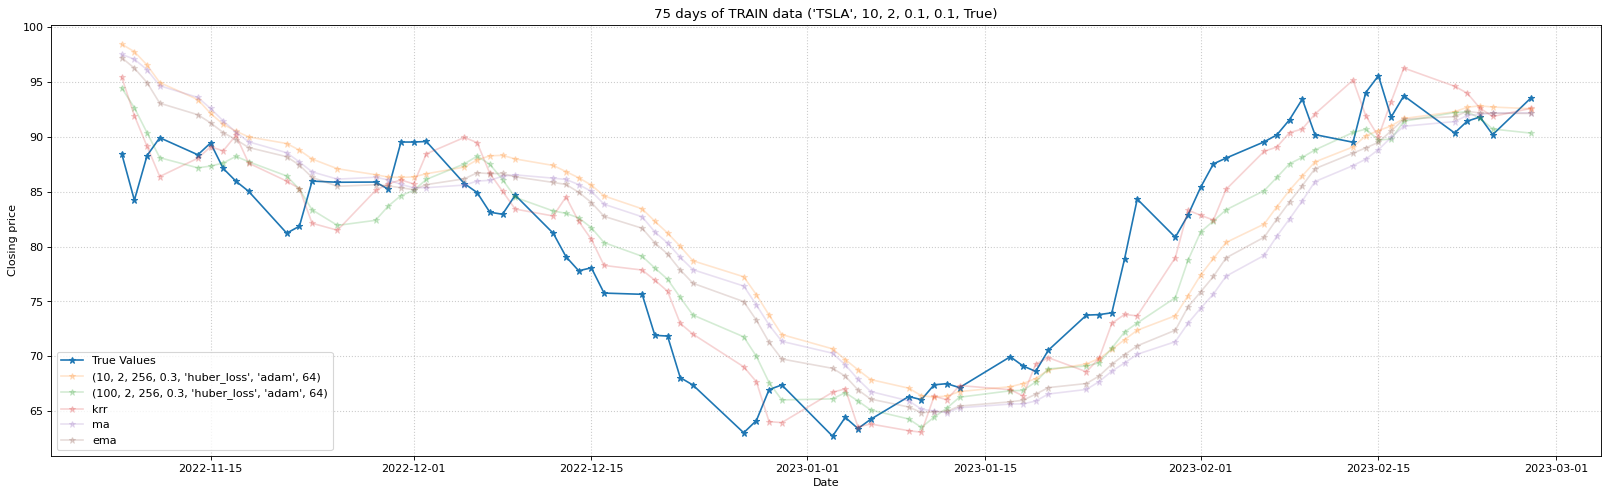

net1 - (10, 2, 256, 0.3, 'huber_loss', 'adam', 64)
net2 - (100, 2, 256, 0.3, 'huber_loss', 'adam', 64)


net1       net2        krr         ma        ema
MSE   38.391879  16.273684  12.469450  43.282000  33.684758
RMSE   6.196118   4.034065   3.531211   6.578906   5.803857
MAPE   6.558402   4.354661   3.696699   6.972702   6.125896
DA     0.594595   0.608108   0.554054   0.608108   0.621622
R²     0.596637   0.829021   0.868990   0.545259   0.646092

3/3 [==============================] - 0s 27ms/step


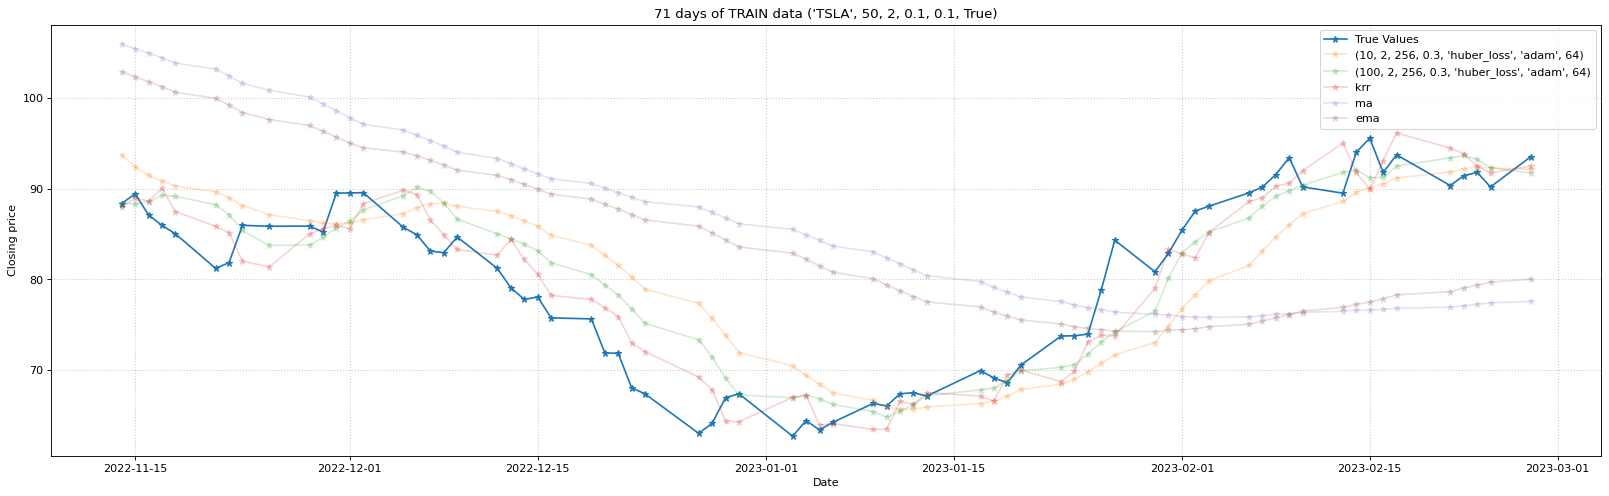

net1 - (10, 2, 256, 0.3, 'huber_loss', 'adam', 64)
net2 - (100, 2, 256, 0.3, 'huber_loss', 'adam', 64)


net1       net2        krr          ma         ema
MSE   38.435168  16.656619  11.258309  225.518077  175.291108
RMSE   6.199610   4.081252   3.355340   15.017259   13.239755
MAPE   6.678386   4.273489   3.554724   18.159399   15.820424
DA     0.600000   0.614286   0.557143    0.514286    0.585714
R²     0.604862   0.828759   0.884257   -1.318470   -0.802105

3/3 [==============================] - 0s 55ms/step


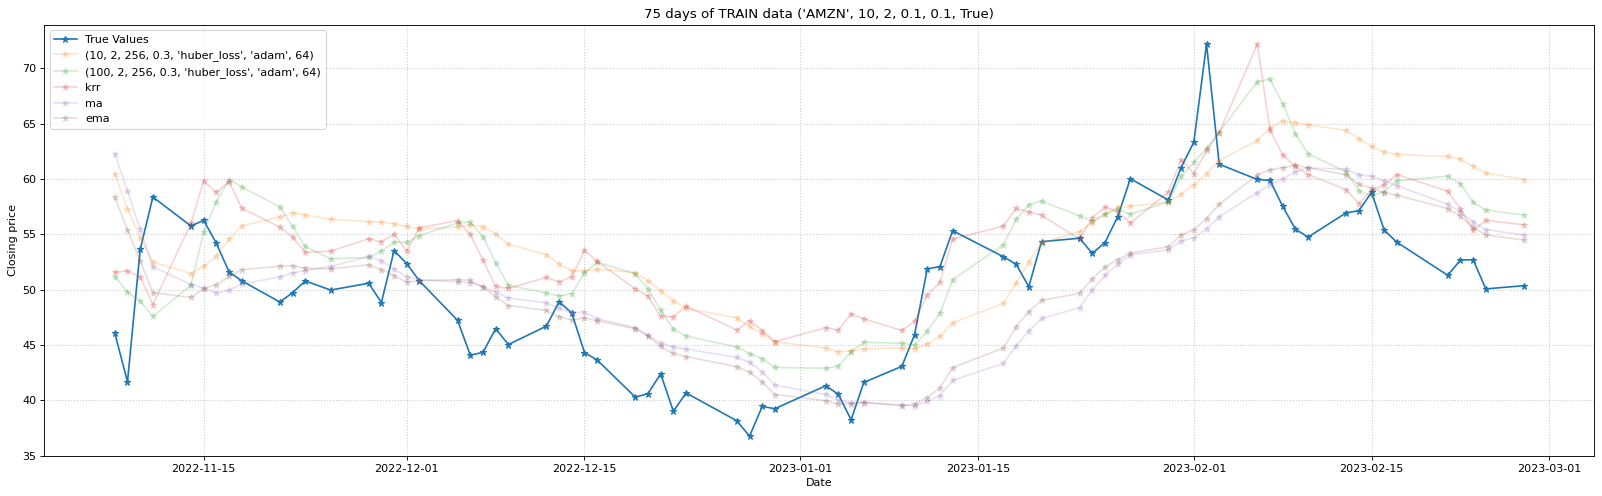

net1 - (10, 2, 256, 0.3, 'huber_loss', 'adam', 64)
net2 - (100, 2, 256, 0.3, 'huber_loss', 'adam', 64)


net1       net2        krr         ma        ema
MSE   49.189941  35.029714  33.966066  35.540914  29.018648
RMSE   7.013554   5.918591   5.828041   5.961620   5.386896
MAPE  12.670244  10.485508  10.543630   9.413698   8.555987
DA     0.486486   0.391892   0.445946   0.500000   0.486486
R²     0.001995   0.289289   0.310869   0.278917   0.411246

3/3 [==============================] - 0s 22ms/step


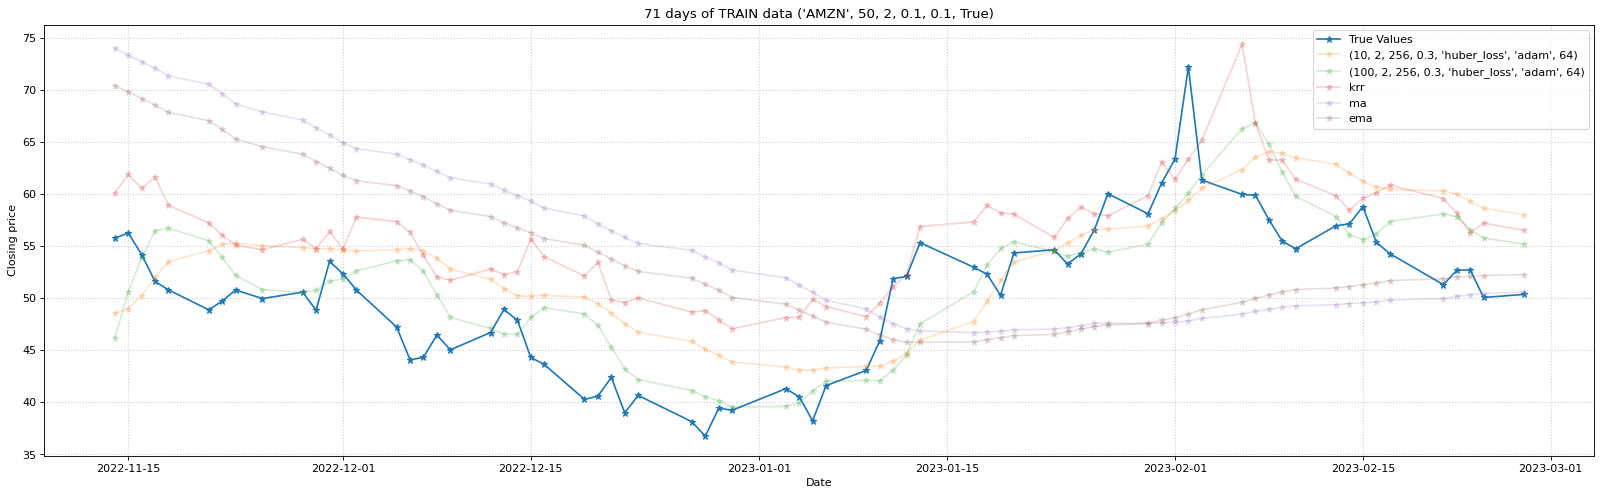

net1 - (10, 2, 256, 0.3, 'huber_loss', 'adam', 64)
net2 - (100, 2, 256, 0.3, 'huber_loss', 'adam', 64)


net1       net2        krr          ma         ema
MSE   34.711000  21.872673  49.417857  170.734190  122.652443
RMSE   5.891604   4.676823   7.029784   13.066529   11.074856
MAPE  10.492351   7.415986  13.118283   24.099599   20.334281
DA     0.514286   0.400000   0.500000    0.528571    0.514286
R²     0.301375   0.559771   0.005372   -2.436349   -1.468612

3/3 [==============================] - 0s 7ms/step


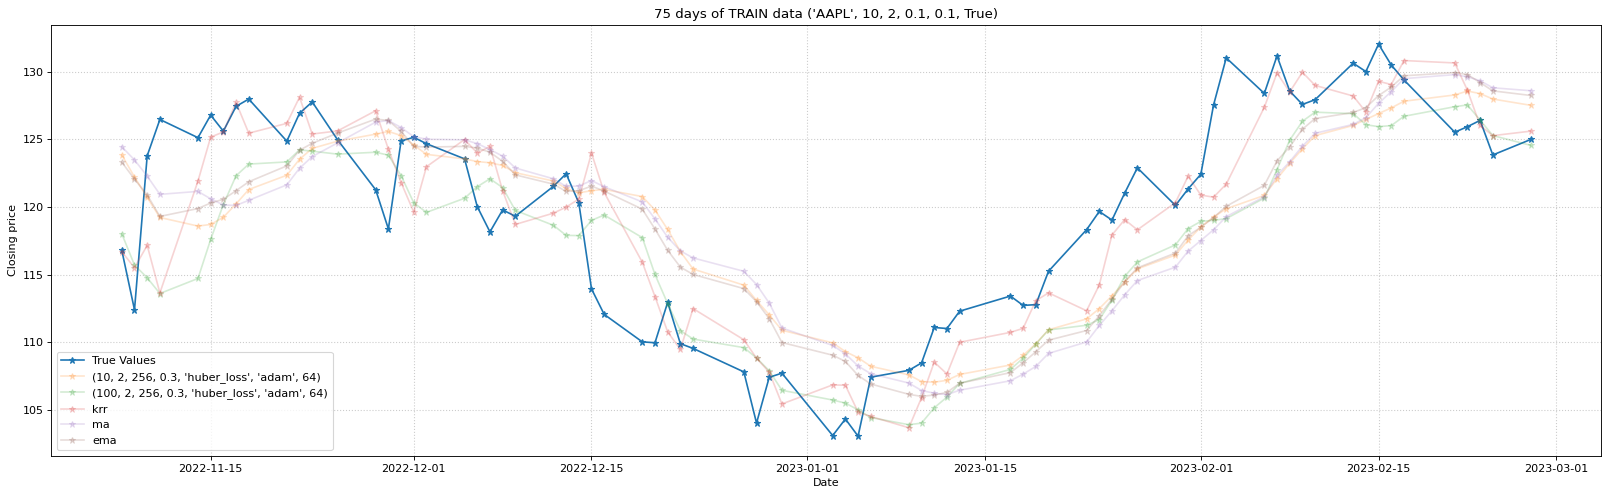

net1 - (10, 2, 256, 0.3, 'huber_loss', 'adam', 64)
net2 - (100, 2, 256, 0.3, 'huber_loss', 'adam', 64)


net1       net2        krr         ma        ema
MSE   29.523058  24.654468  14.608452  33.428000  27.304020
RMSE   5.433512   4.965327   3.822100   5.781695   5.225325
MAPE   3.974450   3.417336   2.440370   4.278929   3.849428
DA     0.527027   0.500000   0.486486   0.500000   0.513514
R²     0.538664   0.614742   0.771724   0.477644   0.573339

3/3 [==============================] - 0s 21ms/step


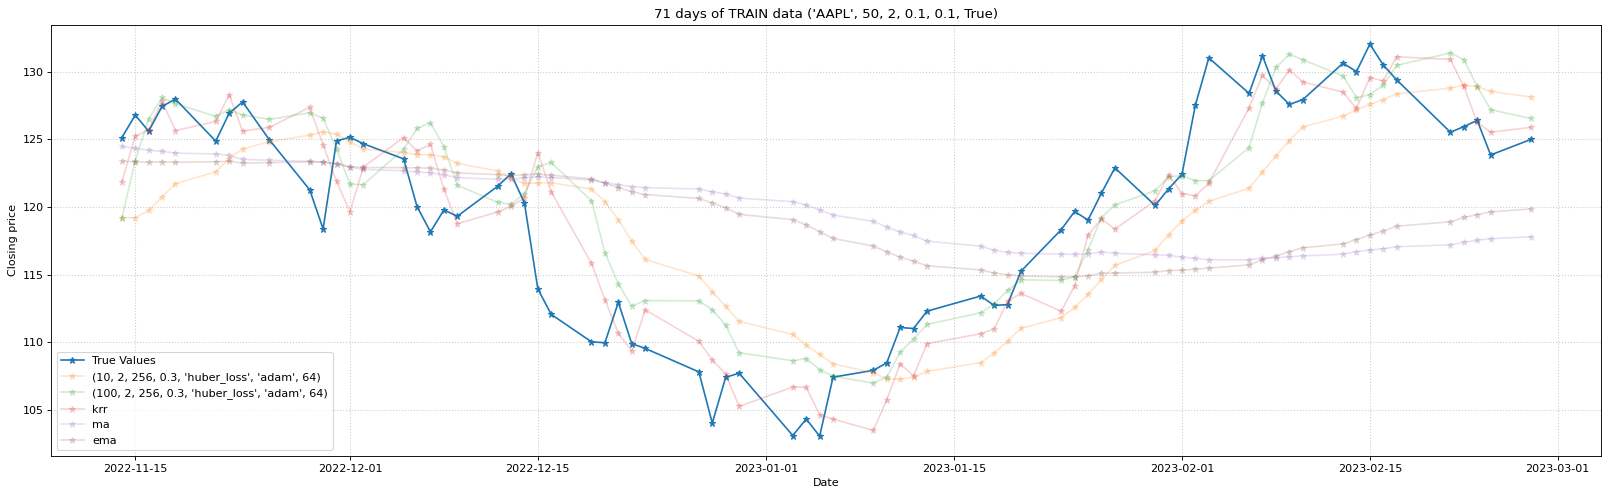

net1 - (10, 2, 256, 0.3, 'huber_loss', 'adam', 64)
net2 - (100, 2, 256, 0.3, 'huber_loss', 'adam', 64)


net1       net2        krr         ma        ema
MSE   28.541571  17.088804  12.541884  80.145559  72.212494
RMSE   5.342431   4.133861   3.541452   8.952405   8.497793
MAPE   3.898118   2.695900   2.345439   6.314518   6.034772
DA     0.528571   0.442857   0.485714   0.442857   0.471429
R²     0.566565   0.740488   0.809538  -0.217097  -0.096625

3/3 [==============================] - 0s 39ms/step


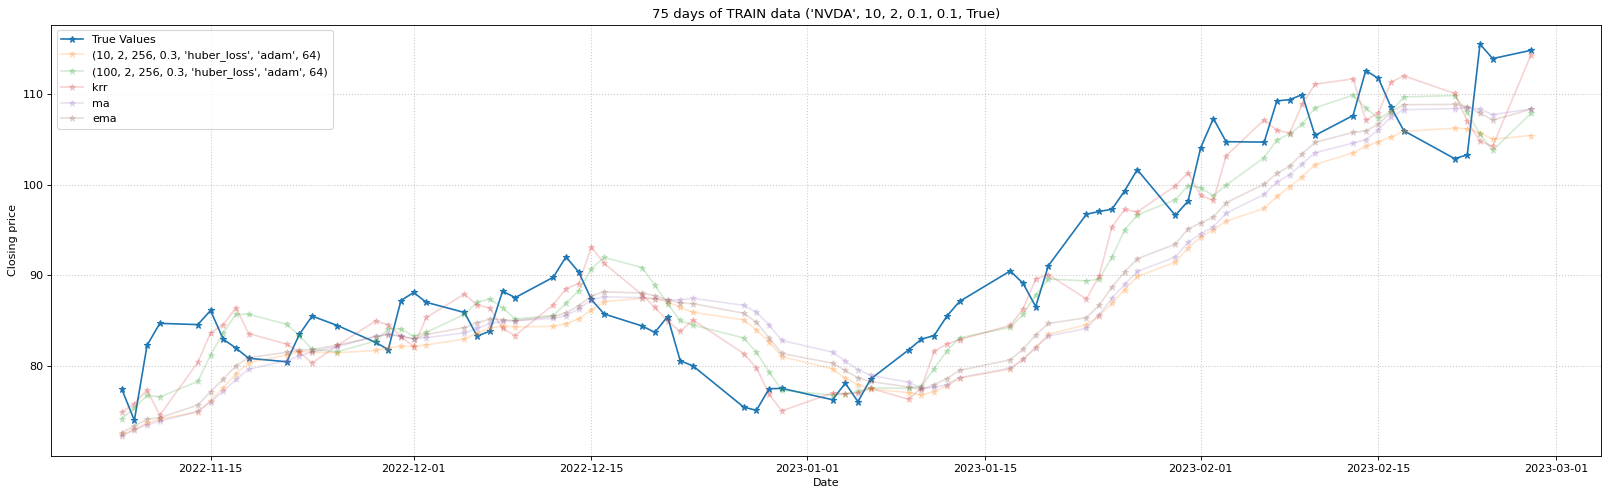

net1 - (10, 2, 256, 0.3, 'huber_loss', 'adam', 64)
net2 - (100, 2, 256, 0.3, 'huber_loss', 'adam', 64)


net1       net2        krr         ma        ema
MSE   44.266516  20.375381  19.350431  41.496482  34.008816
RMSE   6.653309   4.513910   4.398913   6.441776   5.831708
MAPE   6.118232   4.247564   4.089833   6.053834   5.451280
DA     0.513514   0.486486   0.418919   0.486486   0.500000
R²     0.664734   0.845681   0.853444   0.685714   0.742424

3/3 [==============================] - 0s 22ms/step


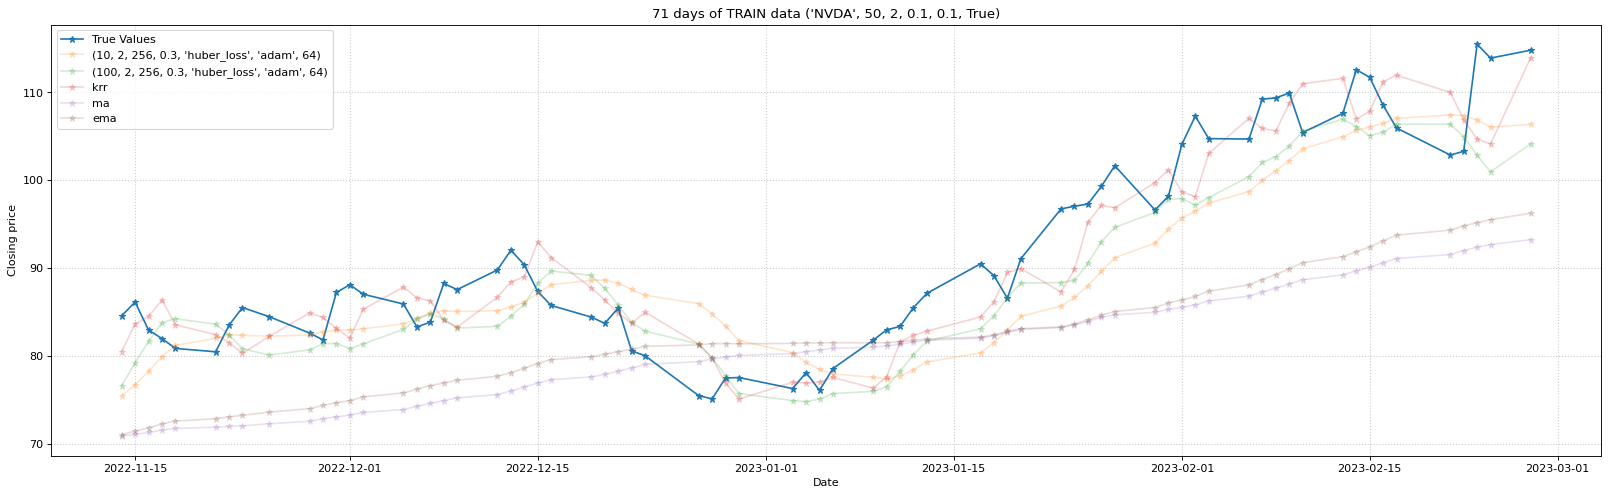

net1 - (10, 2, 256, 0.3, 'huber_loss', 'adam', 64)
net2 - (100, 2, 256, 0.3, 'huber_loss', 'adam', 64)


net1       net2        krr          ma         ema
MSE   36.689865  28.597893  18.632302  170.941159  140.565887
RMSE   6.057216   5.347700   4.316515   13.074447   11.856049
MAPE   5.618953   4.748819   3.994159   12.053982   10.969103
DA     0.514286   0.528571   0.428571    0.528571    0.514286
R²     0.719843   0.781631   0.857727   -0.305277   -0.073337

3/3 [==============================] - 0s 26ms/step


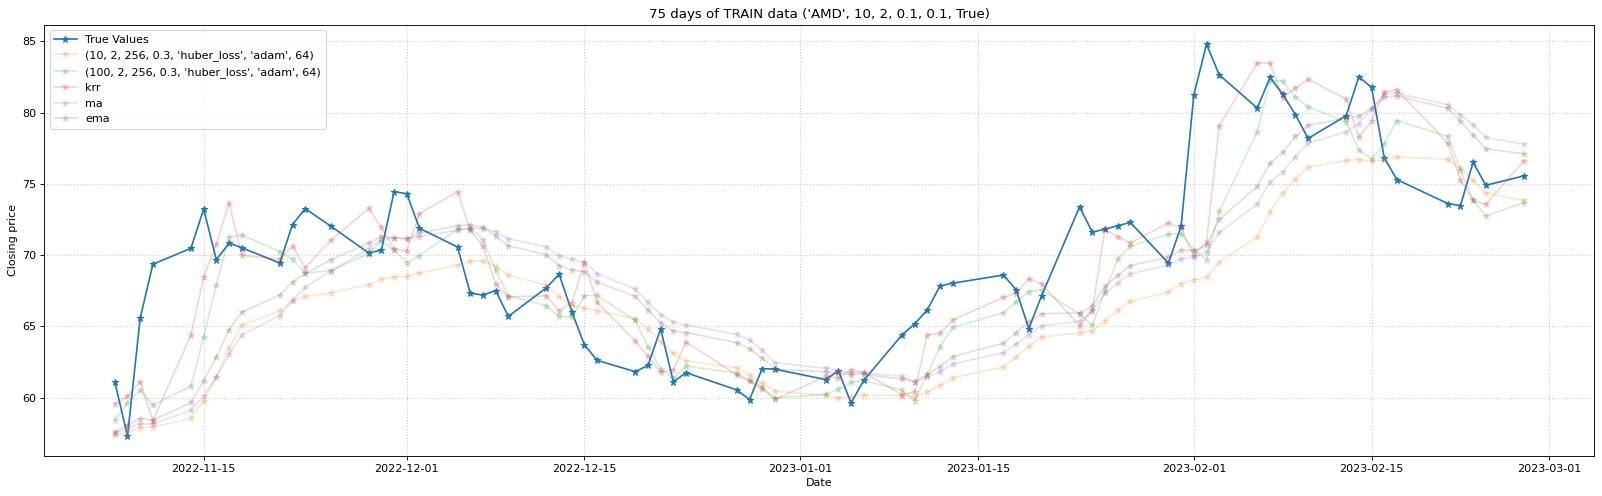

net1 - (10, 2, 256, 0.3, 'huber_loss', 'adam', 64)
net2 - (100, 2, 256, 0.3, 'huber_loss', 'adam', 64)


net1       net2        krr         ma        ema
MSE   31.953781  17.541362  14.604743  28.970701  23.905730
RMSE   5.652768   4.188241   3.821615   5.382444   4.889349
MAPE   6.112398   4.320640   3.974739   6.164539   5.467980
DA     0.527027   0.500000   0.405405   0.540541   0.513514
R²     0.259659   0.593582   0.661621   0.328774   0.446125

3/3 [==============================] - 0s 34ms/step


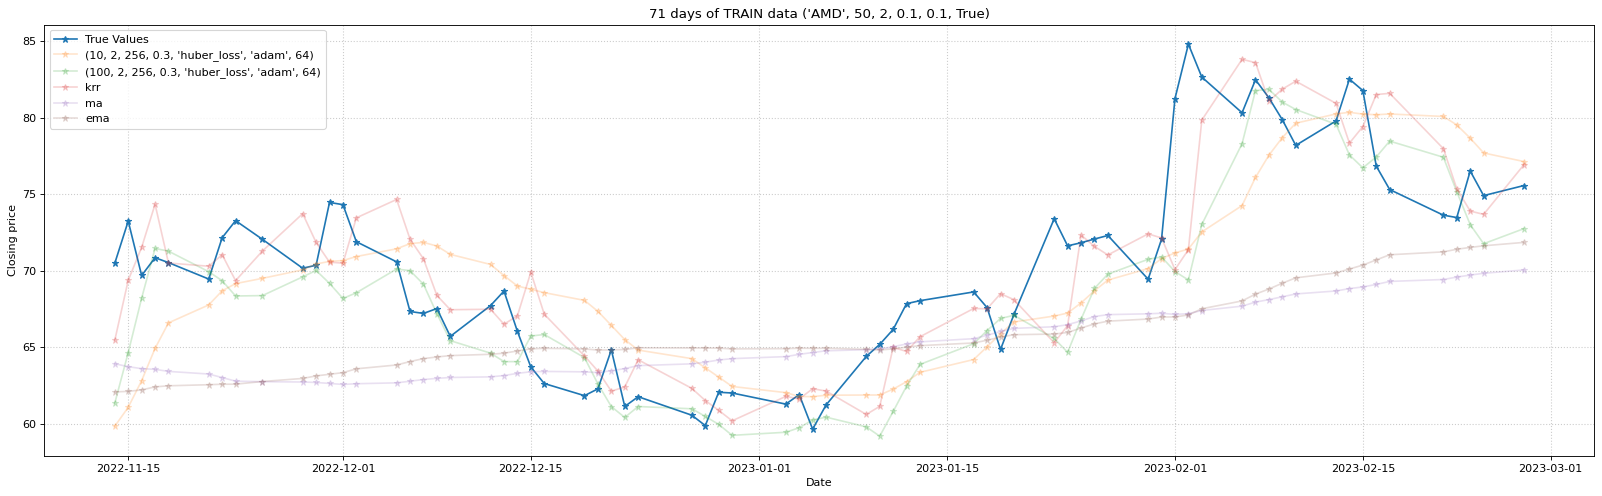

net1 - (10, 2, 256, 0.3, 'huber_loss', 'adam', 64)
net2 - (100, 2, 256, 0.3, 'huber_loss', 'adam', 64)


net1       net2        krr         ma        ema
MSE   21.730774  17.882441  12.907539  53.627178  50.898995
RMSE   4.661628   4.228764   3.592706   7.323058   7.134353
MAPE   5.245614   4.304653   3.795647   8.164496   8.022024
DA     0.571429   0.514286   0.400000   0.471429   0.500000
R²     0.480333   0.572361   0.691331  -0.282434  -0.217193

In [342]:
# Kernel Ridge Regression
from sklearn.kernel_ridge import KernelRidge
def calculate_krr(_data, _scaled):
    krr = KernelRidge(alpha=0.1, kernel='rbf') # why is rbf been used here? and what does the alpha control
    # Train the model on the training data
    krr.fit(_data['xtrain'][:, -1, :], _data['ytrain'])
    # Make predictions on the test data
    pred_krr = krr.predict(_data['xtest'][:, -1, :])
    if _scaled:
        pred_krr = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_krr, axis=0)))
    return pred_krr
# Simple Moving Average
def calculate_ma(_data, _scaled):
    # calcualte the price using a simple moving average
    pred_ma = np.mean(_data["xtest"], axis = 1)
    pred_ma = pred_ma[:, 0] # take only the adjclose price out
    if _scaled:
        pred_ma = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ma, axis=0)))
    return pred_ma
# Exponentila Moving Average
def calculate_ema(_data, _scaled, _window):
    # calculate the price using exponential moving average
    pred_ema = _data["xtest"][:, :, 0] # only take the 
    # pred_EMA = np.squeeze(config["data"]["scaler"].inverse_transform(pred_EMA))
    weights = np.exp(np.linspace(-1, 0, _window))
    weights /= weights.sum()
    pred_ema = pred_ema@weights
    if _scaled:
        pred_ema = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ema, axis=0)))
    return pred_ema
    
# MAKE A FUNCTION FOR EACH COMPARISON TOOL
# Mean Squared Error
calc_mse = lambda y_true, y_pred: np.mean((y_true-y_pred)**2)
# Root Mean Squared Error
calc_rmse = lambda y_true, y_pred: np.sqrt(np.mean((y_true-y_pred)**2))
# Mean Absolute Error
calc_mae = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))
# Mean Absolute Percentage Error
calc_mape = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))*100
# Directional accuracy
calc_da = lambda y_true, y_pred: np.mean([(y_true[i+1]-y_true[i])*(y_pred[i+1]-y_pred[i]) > 0 for i in range(len(y_true)-1)])
# Coefficient of determination R²
calc_cod = lambda y_true, y_pred: 1 - (sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2))
# calculate the statistics
def calc_stats(_actual, _predictions, _nets = []):
    d = {}
    net = 0
    for pred in _predictions:
        prediction = _predictions[pred]
        key = pred
        if pred in _nets:
            net += 1
            key = "net" + str(net)
            print(key, "-", pred) # show the network config
        # go throught the selected methods and get results
        d[key] = [func(_actual, prediction) for func in (calc_mse, calc_rmse, calc_mape, calc_da, calc_cod)]
    # create a dataframe from the information
    df = pd.DataFrame(d)
    df.index = ['MSE', 'RMSE', 'MAPE', 'DA', 'R²'] # set the index of the dataframe
    display(df) # display the dataframe

# to plot results
def plot_predictions(_dates, _y, _predictions, _section, _dataset):
    # plot the results
    fig = plt.figure(figsize=(25, 7), dpi=80)
    # plot the true values
    plt.plot(_dates, _y, "*-", label = "True Values")
    # plot all the predictions
    for pred in _predictions:
        plt.plot(_dates, _predictions[pred], "*-", label = pred, alpha = 0.2)
    plt.legend() # show the labels
    plt.title(f"{len(_y)} days of {_section.upper()} data {_dataset}")
    plt.xlabel("Date")
    plt.ylabel("Closing price")
    plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
    plt.show()

# GET RESULTS FROM ALL THE NETWORKS
section = "train" #train, val, test
# ^^^^^ COULD BE WORKED ON NEXT
for comb in combinations:
    data = datasets[comb["dataset"]]
    # copmare each network against each other
    predictions = {}
    y = data["ytest"]

    # if scaled
    if comb['dataset'][5]:
        y = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(y, axis=0)))
# needs to be updated

    for net in comb["networks"]:
        model = comb["networks"][net]
        # for the training
        predictions[net] = model.predict(data["xtest"])


        # if the data is scaled
        if comb['dataset'][5]:
            predictions[net] = np.squeeze(config["data"]["scaler"].inverse_transform(model.predict(data["xtest"])))
 # needs to be updated

    if 1:
        # add the other methods to compare against
        predictions["krr"] = calculate_krr(data, comb['dataset'][5])
        predictions["ma"] = calculate_ma(data, comb['dataset'][5])
        predictions["ema"] = calculate_ema(data, comb['dataset'][5], comb["dataset"][1])

    plot_predictions(data["testDates"], y, predictions, section, comb['dataset'])
    calc_stats(y, predictions, comb["networks"])
    # break

In [206]:


# get results from all the trained networks
for key, net in trained_nets.items():
    model = net
    data = datasets[key[1]]
    # for the training
    pred_ytrain = model.predict(data["xtrain"])
    ytrain = data["ytrain"]
    # scaler = config["data"]["scaler"]
    pred_ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytrain))
    ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytrain, axis=0)))

    # for the training
    pred_yval = model.predict(data["xval"])
    yval = data["yval"]
    # scaler = config["data"]["scaler"]
    pred_yval = np.squeeze(config["data"]["scaler"].inverse_transform(pred_yval))
    yval = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(yval, axis=0)))

    # for the training
    pred_ytest = model.predict(data["xtest"])
    ytest = data["ytest"]
    # scaler = config["data"]["scaler"]
    pred_ytest = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytest))
    ytest = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytest, axis=0)))
    # ALL 3 TOGETHER
    # plot the results
    fig= plt.figure(figsize=(25, 7), dpi=80)
    # for the training
    plt.plot(data["trainDates"],ytrain) # train data
    plt.plot(data["trainDates"], pred_ytrain)
    plt.plot(data["valDates"], yval) # val data
    plt.plot(data["valDates"], pred_yval)
    plt.plot(data["testDates"], ytest) # test data
    plt.plot(data["testDates"], pred_ytest)
    plt.title(f"ALL DATA of {key}")
    plt.xlabel("x")
    plt.ylabel("Closing price")
    plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
    plt.show()

    # Kernel Ridge Regression
    from sklearn.kernel_ridge import KernelRidge
    krr = KernelRidge(alpha=0.1, kernel='rbf') # why is rbf been used here? and what does the alpha control
    # Train the model on the training data
    krr.fit(data['xtrain'][:, -1, :], data['ytrain'])
    # Make predictions on the test data
    pred_krr = krr.predict(data['xtest'][:, -1, :])
    pred_krr = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_krr, axis=0)))


    # calcualte the price using a simple moving average
    pred_ma = np.mean(data["xtest"], axis = 1)
    pred_ma = pred_ma[:, 0] # take only the adjclose price out
    pred_ma = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ma, axis=0)))

    # calculate the price using exponential moving average
    pred_ema = data["xtest"][:, :, 0] # only take the 
    # pred_EMA = np.squeeze(config["data"]["scaler"].inverse_transform(pred_EMA))
    weights = np.exp(np.linspace(-1, 0, key[0][0]))
    weights /= weights.sum()
    pred_ema = pred_ema@weights
    pred_ema = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ema, axis=0)))

    # plot the results
    fig= plt.figure(figsize=(25, 7), dpi=80)
    plt.plot(ytest, "*-") # actual data
    plt.plot(pred_ytest, "*-") # prediction made by neural network
    plt.plot(pred_ma, "*-")
    plt.plot(pred_ema, "*-")
    plt.plot(pred_krr, "*-")
    plt.title(f"Testing data of {config['data']['ticker']}")
    plt.xlabel("x")
    plt.ylabel("Closing price")
    xticks = 100
    step = round(len(data["raw"]["adjclose"].keys())/xticks)
    plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
    plt.legend("Actual,Neural Network,MA,EMA,KRR".split(","))
    plt.show()

    # compare all the following data
    pairs = [[ytrain, pred_ytrain, 'Training NN'],
            [yval, pred_yval, 'Validation NN'],
            [ytest, pred_ytest, 'Testing NN'],
            [ytest, pred_krr, 'Testing KRR'],
            [ytest, pred_ma, 'Testing MA'],
            [ytest, pred_ema, 'Testing EMA']
            ]
    d = {}
    for pair in pairs:
        d[pair[2]] = []
        d[pair[2]].append(calc_mse(pair[0], pair[1]))
        d[pair[2]].append(calc_rmse(pair[0], pair[1]))
        # d[pair[2]].append(calc_mae(pair[0], pair[1]))
        d[pair[2]].append(calc_mape(pair[0], pair[1]))
        d[pair[2]].append(calc_da(pair[0], pair[1]))
        d[pair[2]].append(calc_cod(pair[0], pair[1]))

    df = pd.DataFrame(data=d)
    df.index = ['MSE', 'RMSE', 'MAPE', 'DA', 'R²']
    display(df)

{'dataset': ('TSLA', 10, 2, 0.1, 0.1, True), 'networks': {(1, 2, 256, 0.3, 'huber_loss', 'adam', 64): <keras.engine.sequential.Sequential object at 0x3839c5540>, (2, 2, 256, 0.3, 'huber_loss', 'adam', 64): <keras.engine.sequential.Sequential object at 0x4642cf880>}}

{'dataset': ('TSLA', 50, 2, 0.1, 0.1, True), 'networks': {(1, 2, 256, 0.3, 'huber_loss', 'adam', 64): <keras.engine.sequential.Sequential object at 0x39ccbf610>, (2, 2, 256, 0.3, 'huber_loss', 'adam', 64): <keras.engine.sequential.Sequential object at 0x4805f3b50>}}

{'dataset': ('AMZN', 10, 2, 0.1, 0.1, True), 'networks': {(1, 2, 256, 0.3, 'huber_loss', 'adam', 64): <keras.engine.sequential.Sequential object at 0x471e3e620>, (2, 2, 256, 0.3, 'huber_loss', 'adam', 64): <keras.engine.sequential.Sequential object at 0x319355090>}}

{'dataset': ('AMZN', 50, 2, 0.1, 0.1, True), 'networks': {(1, 2, 256, 0.3, 'huber_loss', 'adam', 64): <keras.engine.sequential.Sequential object at 0x3f664c940>, (2, 2, 256, 0.3, 'huber_loss', 'ad

In [124]:
import itertools
# setup different models
networks = {} # setup a dictionary to save all the models generated
for opts in itertools.product(windows, layers, num_neurons, dropouts, loss_functions, optimizers):
    print(opts)
    # create a model using the options in CONFIG
    model = generateModel(opts[0], opts[1], opts[2], n_features= config["nn"]["nFeatures"], dropout= opts[3], loss= opts[4], optimizer= opts[5], layerType= config["nn"]["layerType"])
    # store the models in a dictionary
    networks[opts] = model

# download all the different data
stocks = {}
for ticker in tickers:
    stocks[ticker] = getData(ticker, config["data"]["offset"])

(10, 2, 256, 0.3, 'huber_loss', 'adam')
(50, 2, 256, 0.3, 'huber_loss', 'adam')
TSLA data has been imported between 2020-02-27 and the 2023-02-27, for a total of 755 days of data
AMZN data has been imported between 2020-02-27 and the 2023-02-27, for a total of 755 days of data


In [112]:
# setup the different data with different settings
# process all the different data
datasets = {}
for opts in itertools.product(tickers, windows, lookaheads, validations, tests, scaled):
    print(opts)
    # process the data with all of the settings
    datasets[opts] = setupData(stocks[opts[0]], opts[1], opts[2], opts[3], opts[4], opts[5], config["data"]["scaler"], config["data"]["inputs"])

('TSLA', 10, 2, 0.1, 0.1, True)
('TSLA', 50, 2, 0.1, 0.1, True)
('AMZN', 10, 2, 0.1, 0.1, True)
('AMZN', 50, 2, 0.1, 0.1, True)


In [113]:
# train the models
trained_nets = {}
for opts in itertools.product(networks.keys(), datasets.keys(), epochs, batch_sizes):
    # only train if the windows match
    if opts[0][0] == opts[1][1]:
        trained_nets[opts] = networks[opts[0]]
        print(opts)
        trained_nets[opts].fit(datasets[opts[1]]["xtrain"], datasets[opts[1]]["ytrain"], batch_size= opts[3], epochs= opts[2], validation_data=(datasets[opts[1]]["xval"], datasets[opts[1]]["yval"]), verbose=1)

# for key, data in m.items():
#     print(key)

# show the results
# for key, data in datasets.items():
#     print(key, data.keys())
#     plots = "trainDates ytrain,valDates yval,testDates ytest"
#     lines = 100
#     fig = plt.figure(figsize=(25, 7), dpi=80)
#     # plot all the different lines
#     for plot in plots.split(","):
#         x, y = plot.split()
#         plt.plot(data[f"{x}"], data[f"{y}"])
#     step = round(len(data["raw"]["adjclose"].keys())/lines)
#     plt.xticks(data["ydates"][::step], rotation='vertical') 
#     # Plot the grid lines
#     plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
#     scaled = lambda x: "Scaled " if x == True else None
#     plt.title(f"{scaled(config['data']['scale'])}Adjusted Closing Price of {key}", fontsize=16)
#     # Define the labels for x-axis and y-axis
#     plt.ylabel(f"{scaled(config['data']['scale'])}Adjusted Closing Price", fontsize=14)
#     plt.xlabel("Date", fontsize=14)
#     plt.legend("Train,Validation,Test".split(","))
#     # show the plot
#     plt.show()

((10, 2, 256, 0.3, 'huber_loss', 'adam'), ('TSLA', 10, 2, 0.1, 0.1, True), 1, 64)


2023-02-27 21:48:57.964316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:48:58.181705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:48:58.344817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:48:58.595692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:48:58.790125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.1944

2023-02-27 21:48:59.883107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:48:59.958030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:00.021562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 4s 143ms/step - loss: 0.0370 - mean_absolute_error: 0.1944 - val_loss: 0.0131 - val_mean_absolute_error: 0.1524
((10, 2, 256, 0.3, 'huber_loss', 'adam'), ('TSLA', 10, 2, 0.1, 0.1, True), 2, 64)
Epoch 1/2
10/10 [==============================] - 0s 39ms/step - loss: 0.0053 - mean_absolute_error: 0.0811 - val_loss: 0.0014 - val_mean_absolute_error: 0.0431
Epoch 2/2
10/10 [==============================] - 0s 39ms/step - loss: 0.0029 - mean_absolute_error: 0.0554 - val_loss: 0.0024 - val_mean_absolute_error: 0.0556
((10, 2, 256, 0.3, 'huber_loss', 'adam'), ('AMZN', 10, 2, 0.1, 0.1, True), 1, 64)
10/10 [==============================] - 0s 31ms/step - loss: 0.0031 - mean_absolute_error: 0.0608 - val_loss: 0.0037 - val_mean_absolute_error: 0.0701
((10, 2, 256, 0.3, 'huber_loss', 'adam'), ('AMZN', 10, 2, 0.1, 0.1, True), 2, 64)
Epoch 1/2
10/10 [==============================] - 0s 30ms/step - loss: 0.0028 - mean_absolute_error: 0.0574 - val_loss: 0.00

2023-02-27 21:49:03.446364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:03.654132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:03.805955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:04.049173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/9 [==>...........................] - ETA: 19s - loss: 0.1782 - mean_absolute_error: 0.5589

2023-02-27 21:49:04.304594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.0478 - mean_absolute_error: 0.2340

2023-02-27 21:49:05.782343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:05.858981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-27 21:49:05.979124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 4s 227ms/step - loss: 0.0478 - mean_absolute_error: 0.2340 - val_loss: 0.0083 - val_mean_absolute_error: 0.1138
((50, 2, 256, 0.3, 'huber_loss', 'adam'), ('TSLA', 50, 2, 0.1, 0.1, True), 2, 64)
Epoch 1/2
9/9 [==============================] - 0s 55ms/step - loss: 0.0062 - mean_absolute_error: 0.0873 - val_loss: 0.0027 - val_mean_absolute_error: 0.0627
Epoch 2/2
9/9 [==============================] - 0s 52ms/step - loss: 0.0039 - mean_absolute_error: 0.0664 - val_loss: 0.0041 - val_mean_absolute_error: 0.0749
((50, 2, 256, 0.3, 'huber_loss', 'adam'), ('AMZN', 50, 2, 0.1, 0.1, True), 1, 64)
9/9 [==============================] - 0s 51ms/step - loss: 0.0038 - mean_absolute_error: 0.0665 - val_loss: 0.0046 - val_mean_absolute_error: 0.0788
((50, 2, 256, 0.3, 'huber_loss', 'adam'), ('AMZN', 50, 2, 0.1, 0.1, True), 2, 64)
Epoch 1/2
9/9 [==============================] - 0s 45ms/step - loss: 0.0029 - mean_absolute_error: 0.0578 - val_loss: 0.0048 - val_m

3/3 [==============================] - 0s 9ms/step


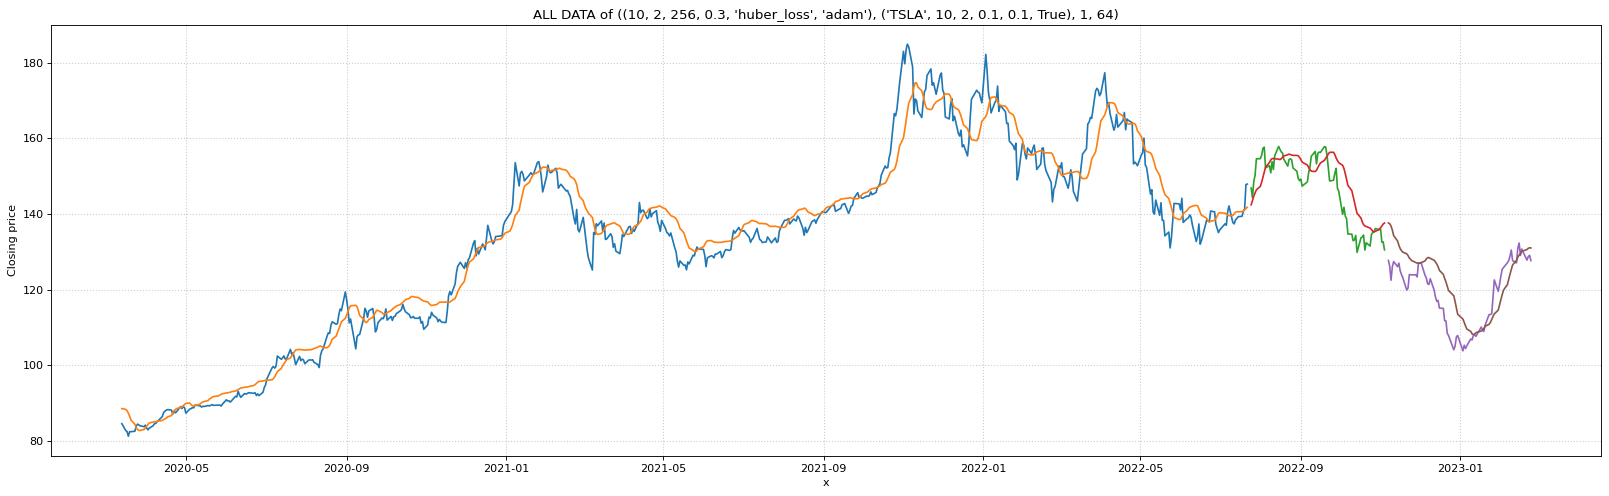

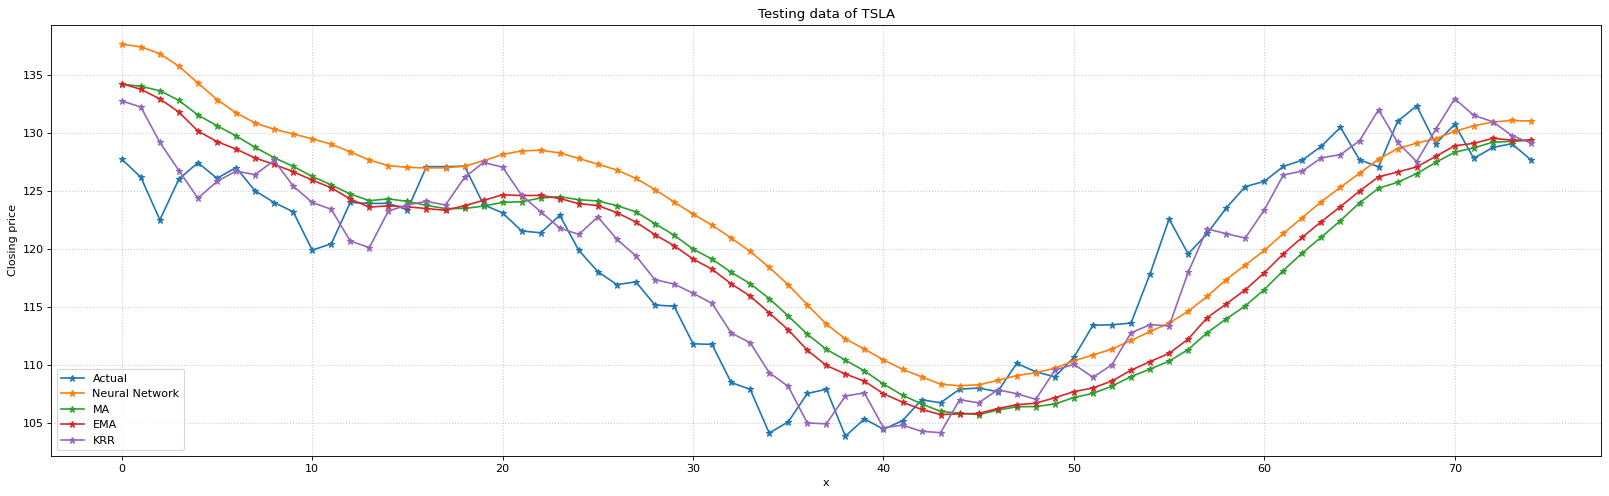

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     27.119308      32.125907   43.076969     9.715144   33.113784   
RMSE     5.207620       5.667972    6.563305     3.116913    5.754458   
MAPE     2.811787       3.175840    4.586855     2.188323    4.086181   
DA       0.533670       0.479452    0.608108     0.554054    0.608108   
R²       0.956521       0.621400    0.392340     0.862955    0.532885   

      Testing EMA  
MSE     25.897184  
RMSE     5.088928  
MAPE     3.597360  
DA       0.635135  
R²       0.634685

3/3 [==============================] - 0s 7ms/step


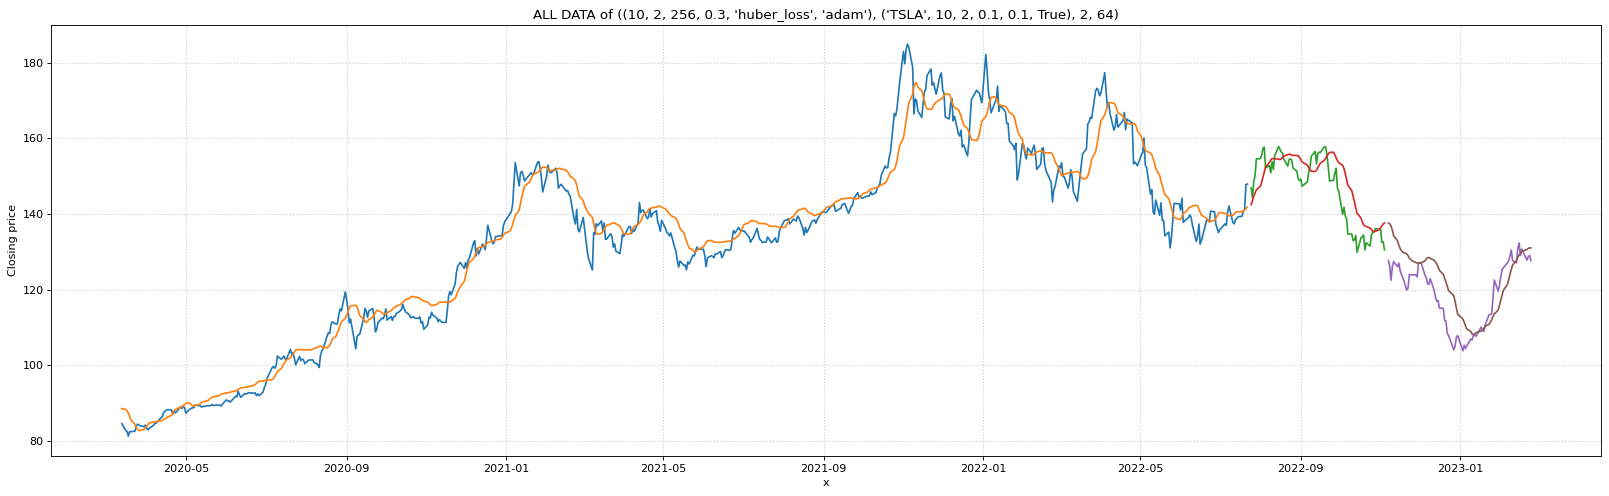

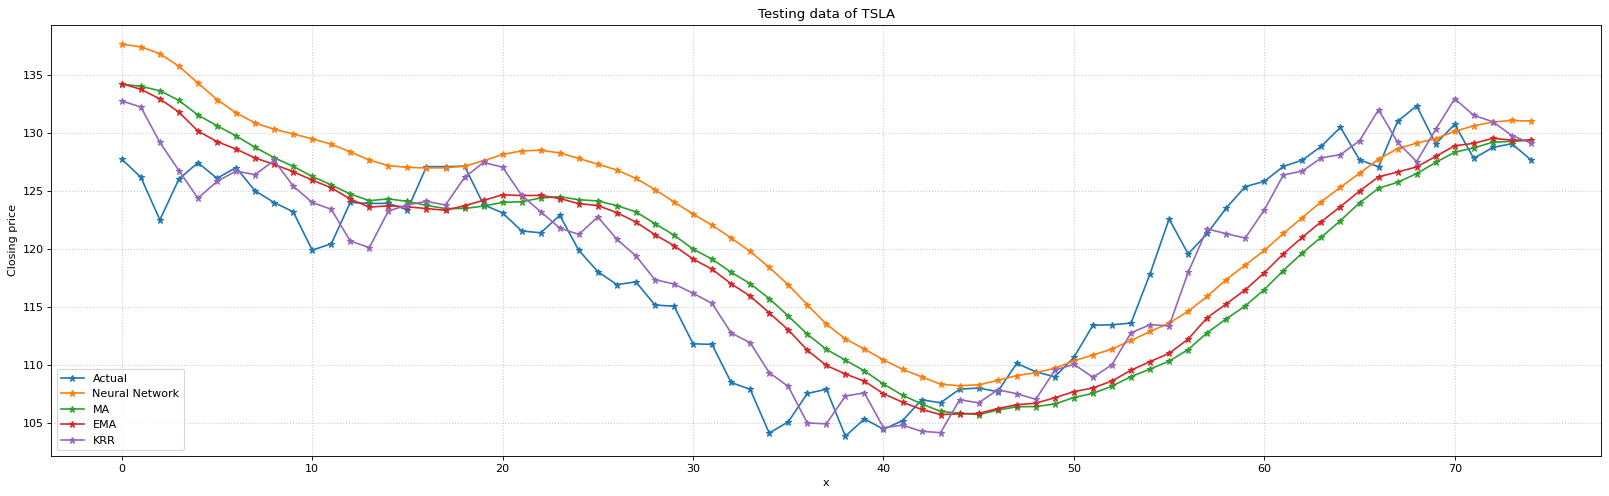

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     27.119308      32.125907   43.076969     9.715144   33.113784   
RMSE     5.207620       5.667972    6.563305     3.116913    5.754458   
MAPE     2.811787       3.175840    4.586855     2.188323    4.086181   
DA       0.533670       0.479452    0.608108     0.554054    0.608108   
R²       0.956521       0.621400    0.392340     0.862955    0.532885   

      Testing EMA  
MSE     25.897184  
RMSE     5.088928  
MAPE     3.597360  
DA       0.635135  
R²       0.634685

3/3 [==============================] - 0s 9ms/step


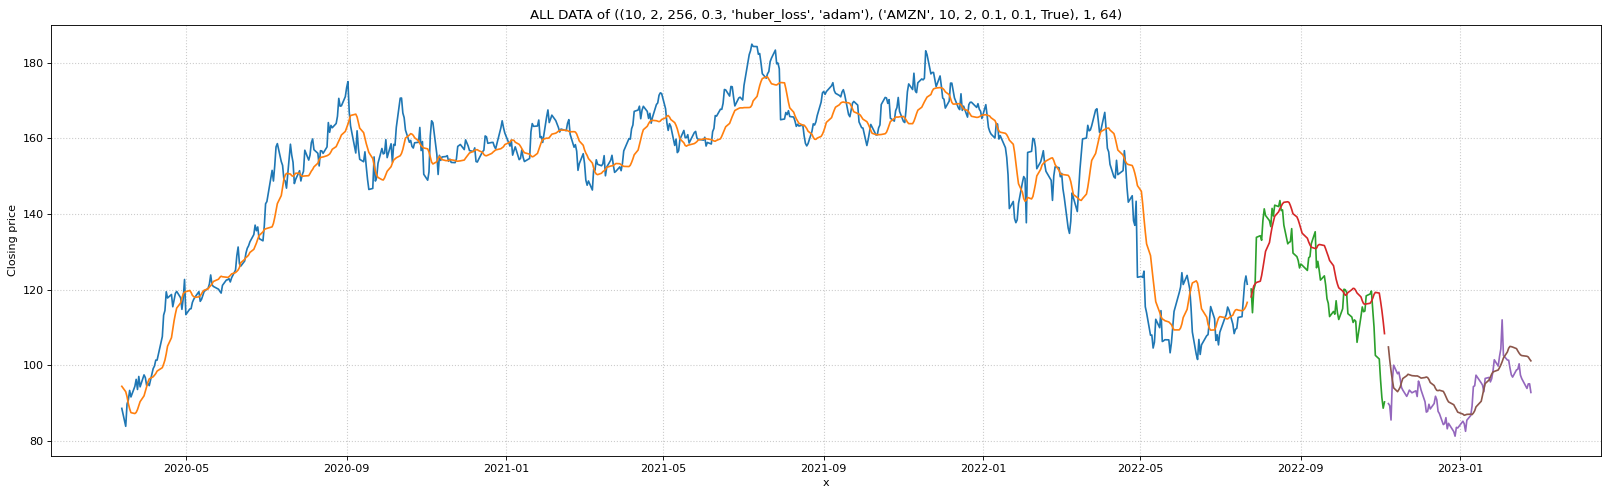

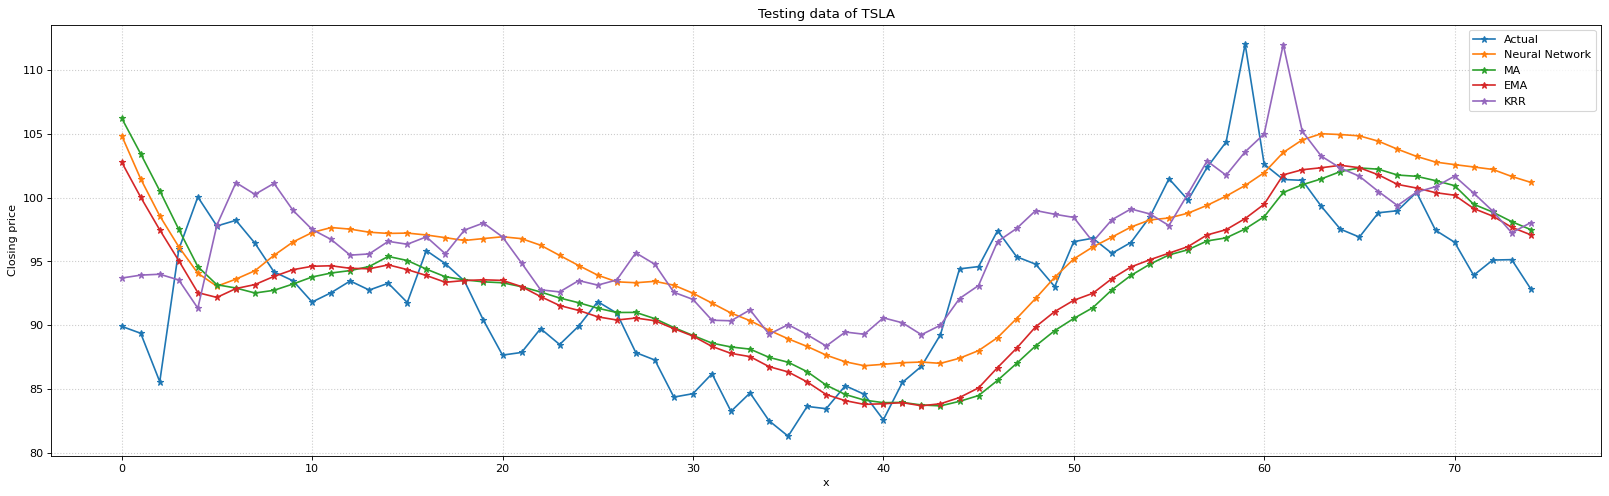

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     44.163843      86.052719   33.586390    23.967551   30.088705   
RMSE     6.645588       9.276460    5.795377     4.895667    5.485317   
MAPE     3.468451       6.538713    5.334824     4.572693    4.562467   
DA       0.491582       0.493151    0.486486     0.445946    0.513514   
R²       0.907979       0.476810    0.097896     0.356251    0.191841   

      Testing EMA  
MSE     23.878797  
RMSE     4.886594  
MAPE     4.124785  
DA       0.500000  
R²       0.358635

3/3 [==============================] - 0s 11ms/step


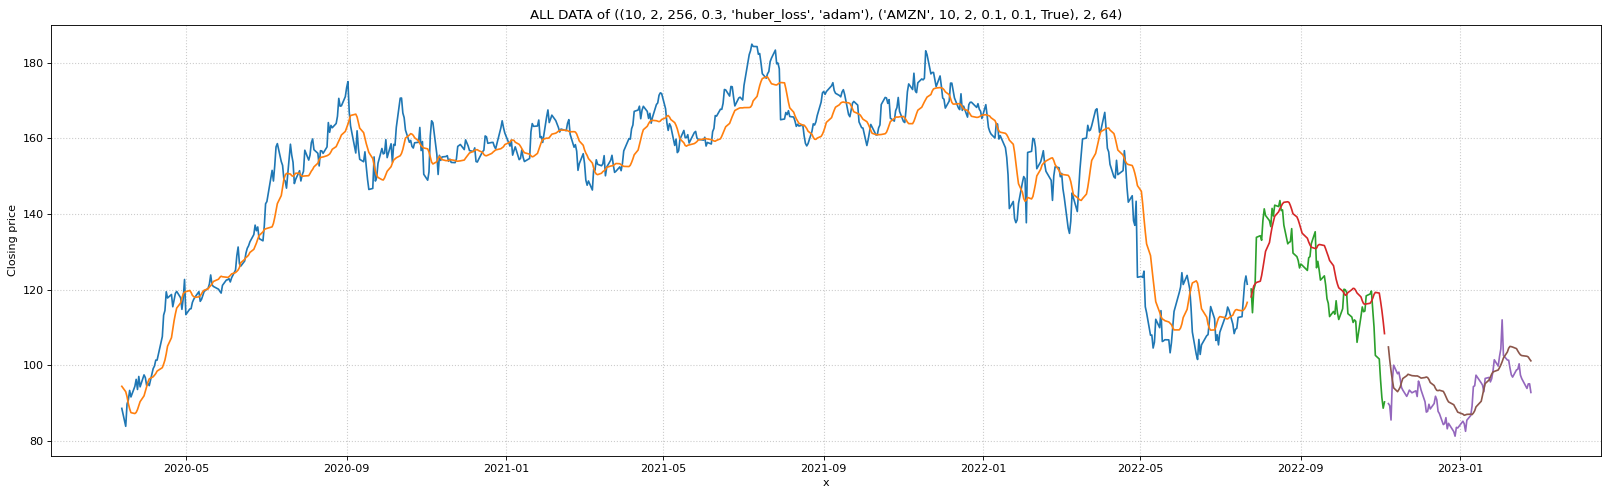

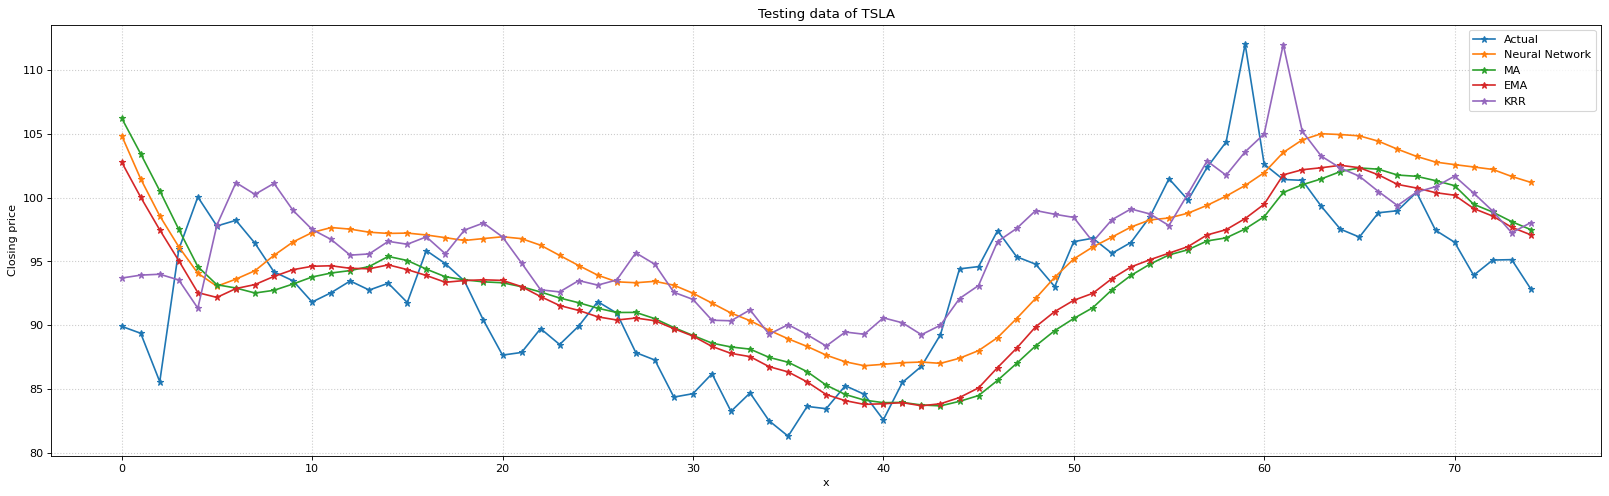

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     44.163843      86.052719   33.586390    23.967551   30.088705   
RMSE     6.645588       9.276460    5.795377     4.895667    5.485317   
MAPE     3.468451       6.538713    5.334824     4.572693    4.562467   
DA       0.491582       0.493151    0.486486     0.445946    0.513514   
R²       0.907979       0.476810    0.097896     0.356251    0.191841   

      Testing EMA  
MSE     23.878797  
RMSE     4.886594  
MAPE     4.124785  
DA       0.500000  
R²       0.358635

3/3 [==============================] - 0s 28ms/step


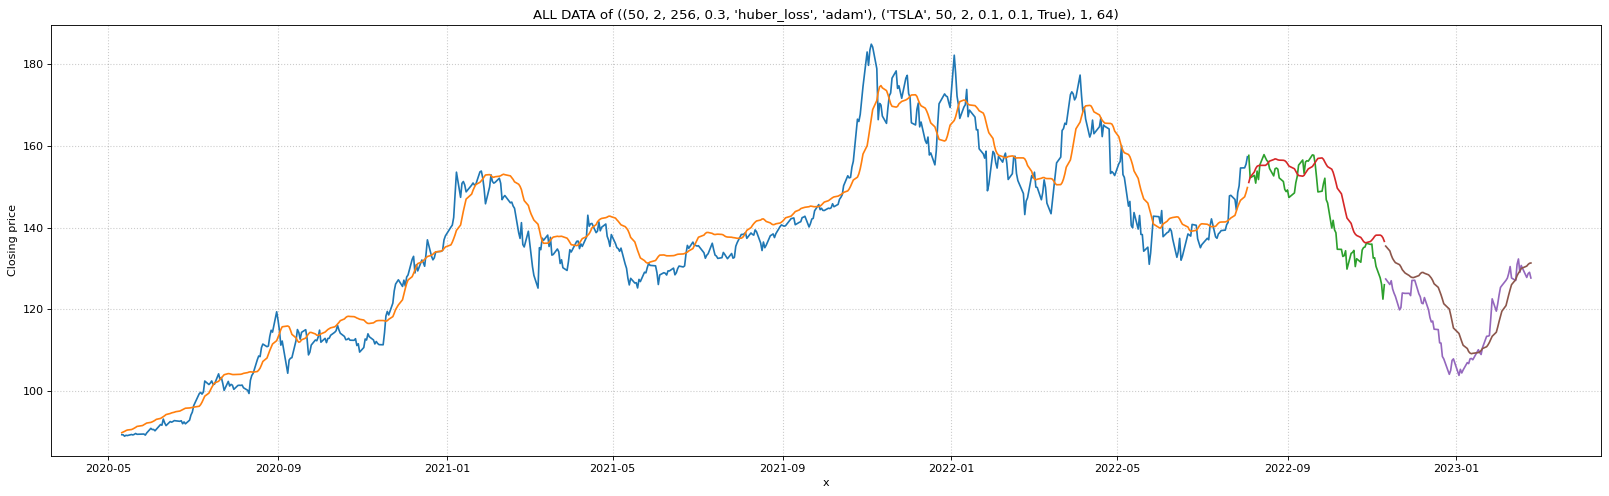

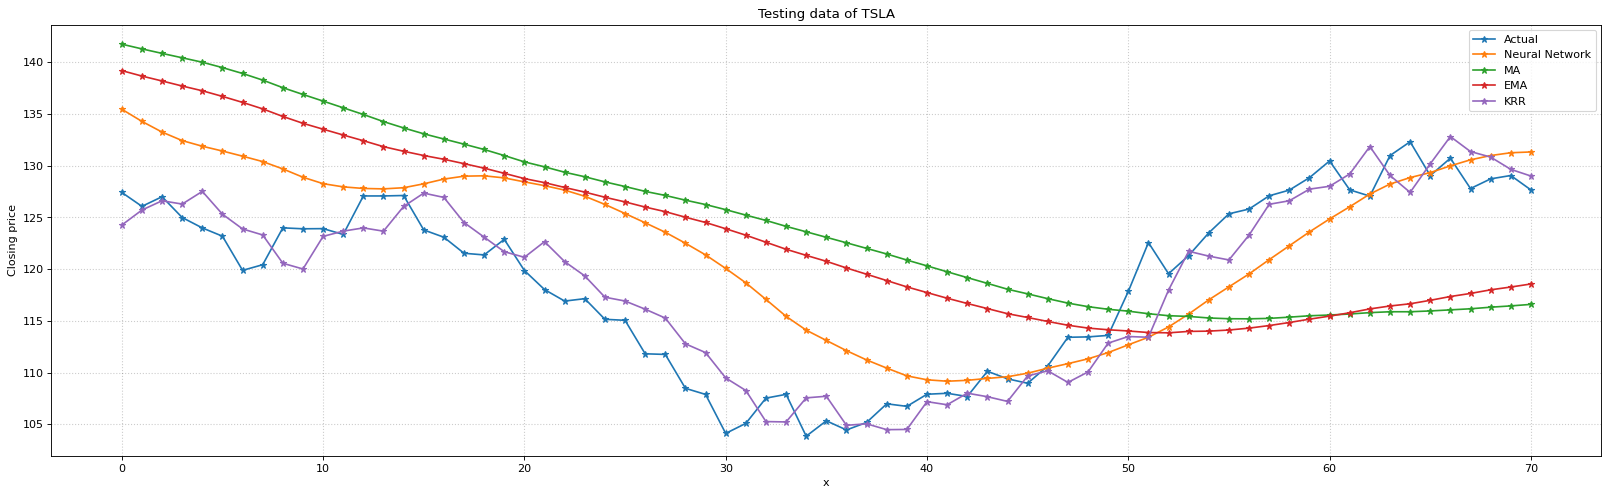

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     32.991605      48.819729   49.949015     8.603780  169.921437   
RMSE     5.743832       6.987112    7.067462     2.933220   13.035392   
MAPE     3.139381       3.965914    5.041390     2.080039   10.452921   
DA       0.540925       0.463768    0.585714     0.542857    0.514286   
R²       0.933700       0.544219    0.309349     0.881034   -1.349525   

      Testing EMA  
MSE    131.947238  
RMSE    11.486829  
MAPE     9.115134  
DA       0.585714  
R²      -0.824451

3/3 [==============================] - 0s 17ms/step


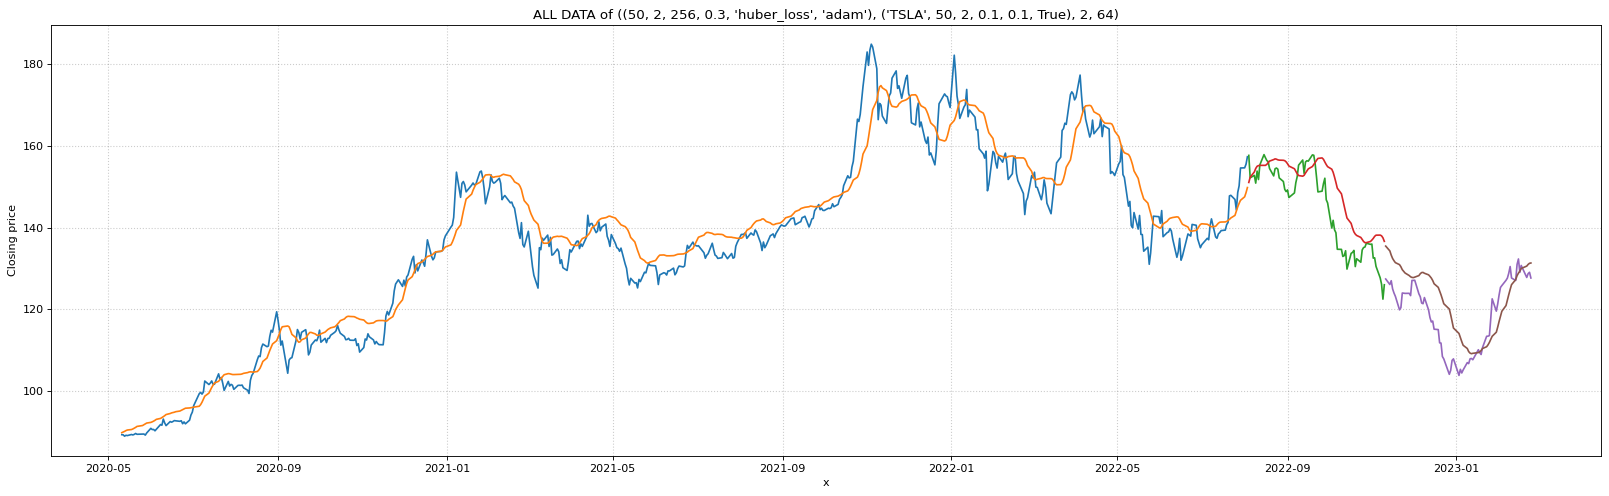

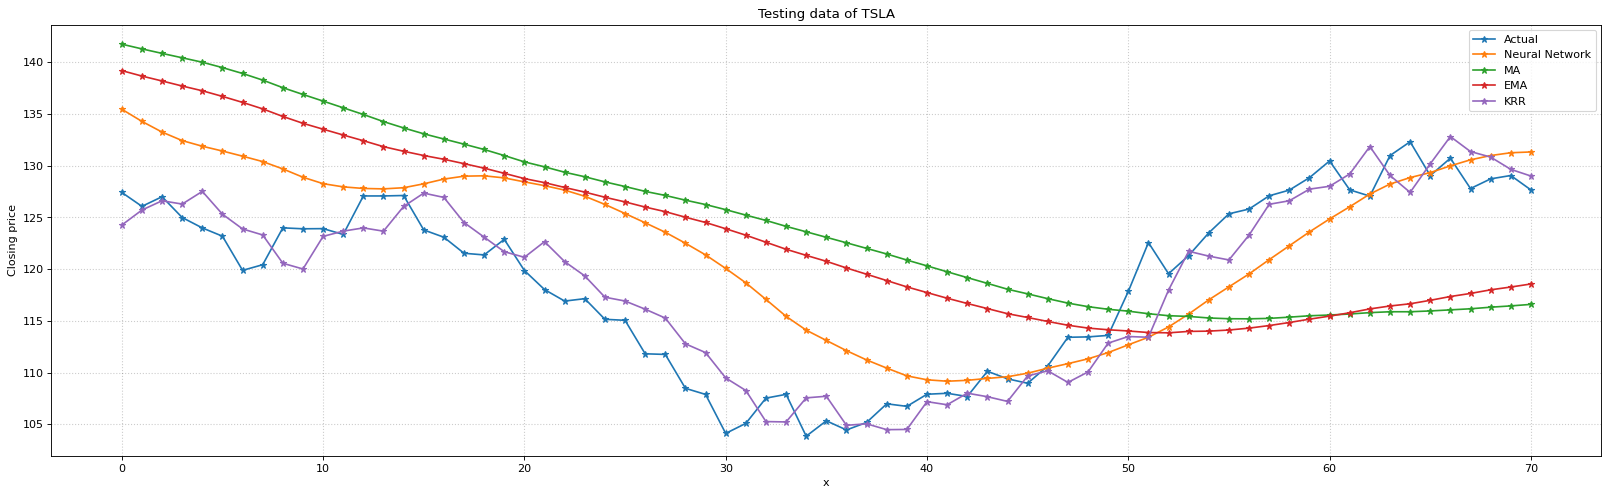

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     32.991605      48.819729   49.949015     8.603780  169.921437   
RMSE     5.743832       6.987112    7.067462     2.933220   13.035392   
MAPE     3.139381       3.965914    5.041390     2.080039   10.452921   
DA       0.540925       0.463768    0.585714     0.542857    0.514286   
R²       0.933700       0.544219    0.309349     0.881034   -1.349525   

      Testing EMA  
MSE    131.947238  
RMSE    11.486829  
MAPE     9.115134  
DA       0.585714  
R²      -0.824451

3/3 [==============================] - 0s 19ms/step


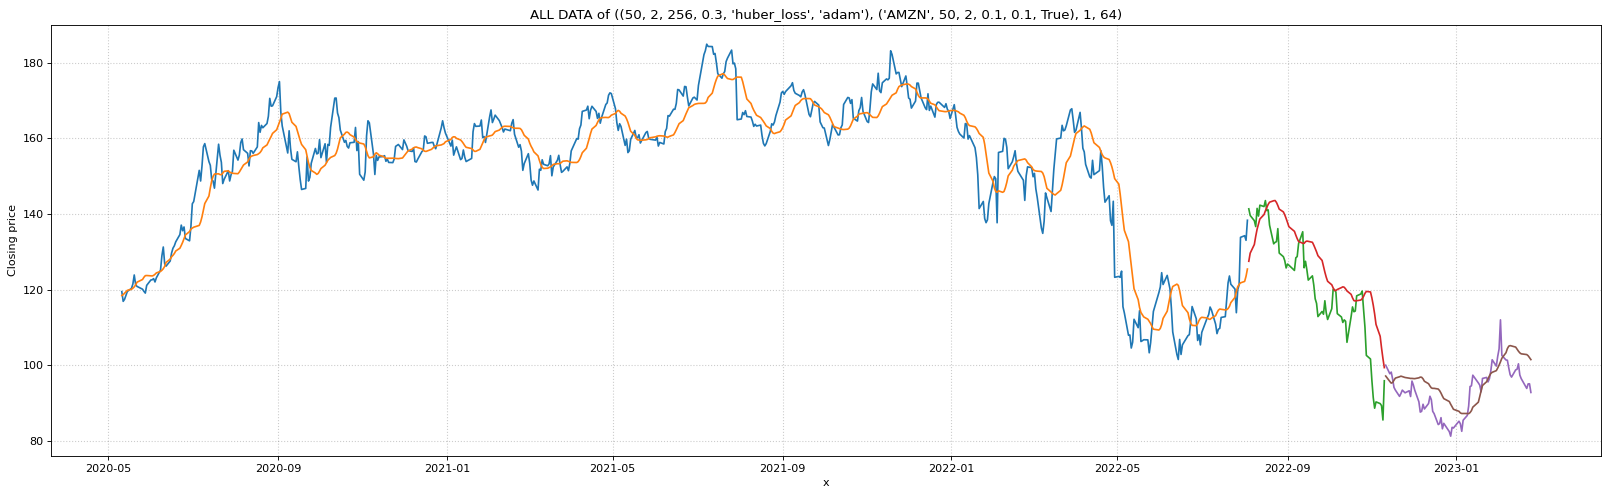

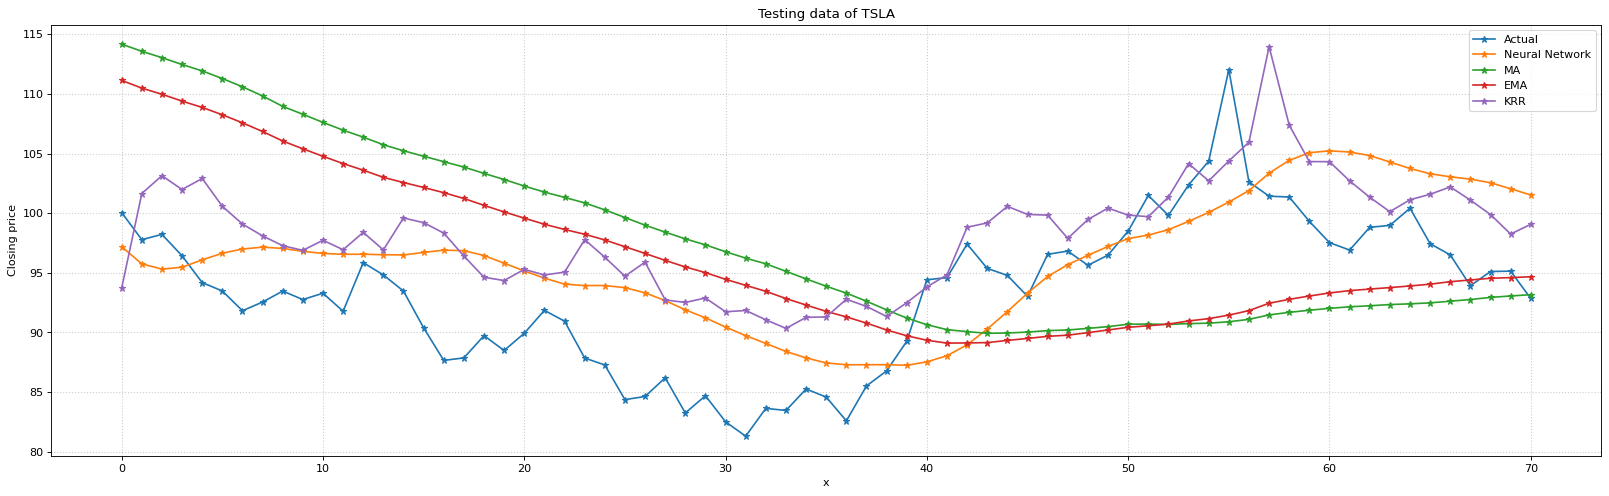

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     47.508294     110.007219   29.531121    37.968501  131.299272   
RMSE     6.892626      10.488433    5.434254     6.161859   11.458589   
MAPE     3.484255       7.764645    5.102725     5.979233   11.239135   
DA       0.491103       0.521739    0.485714     0.500000    0.528571   
R²       0.866464       0.496209    0.223879     0.002133   -2.450736   

      Testing EMA  
MSE     93.997416  
RMSE     9.695226  
MAPE     9.482228  
DA       0.514286  
R²      -1.470389

3/3 [==============================] - 0s 16ms/step


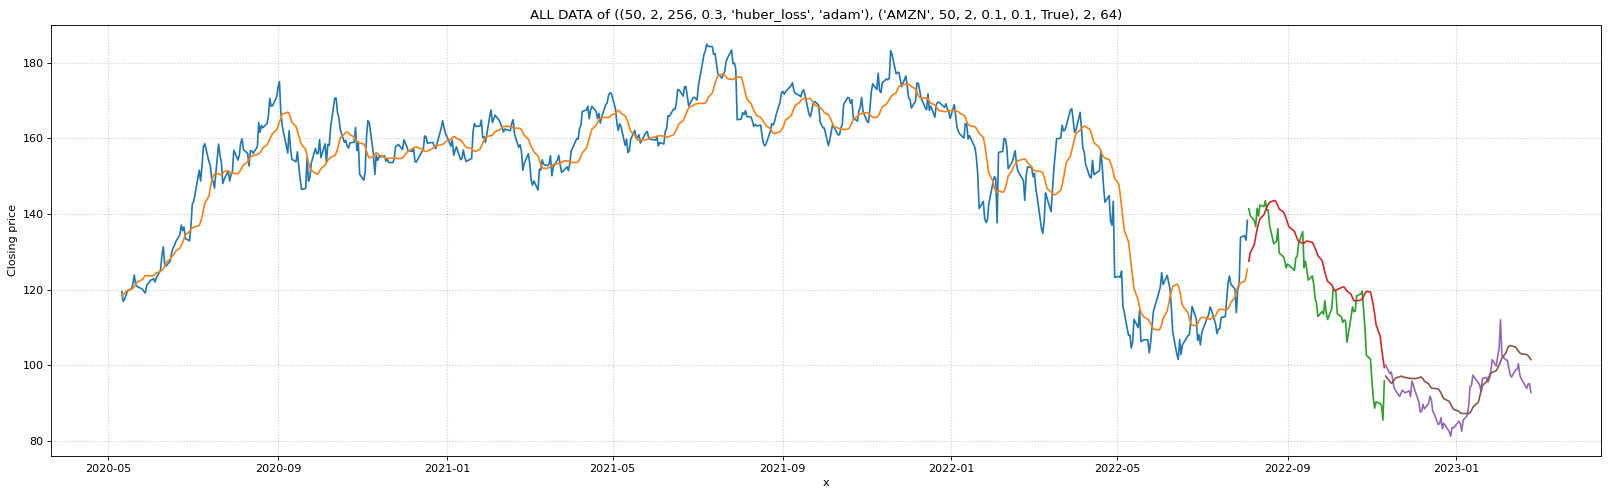

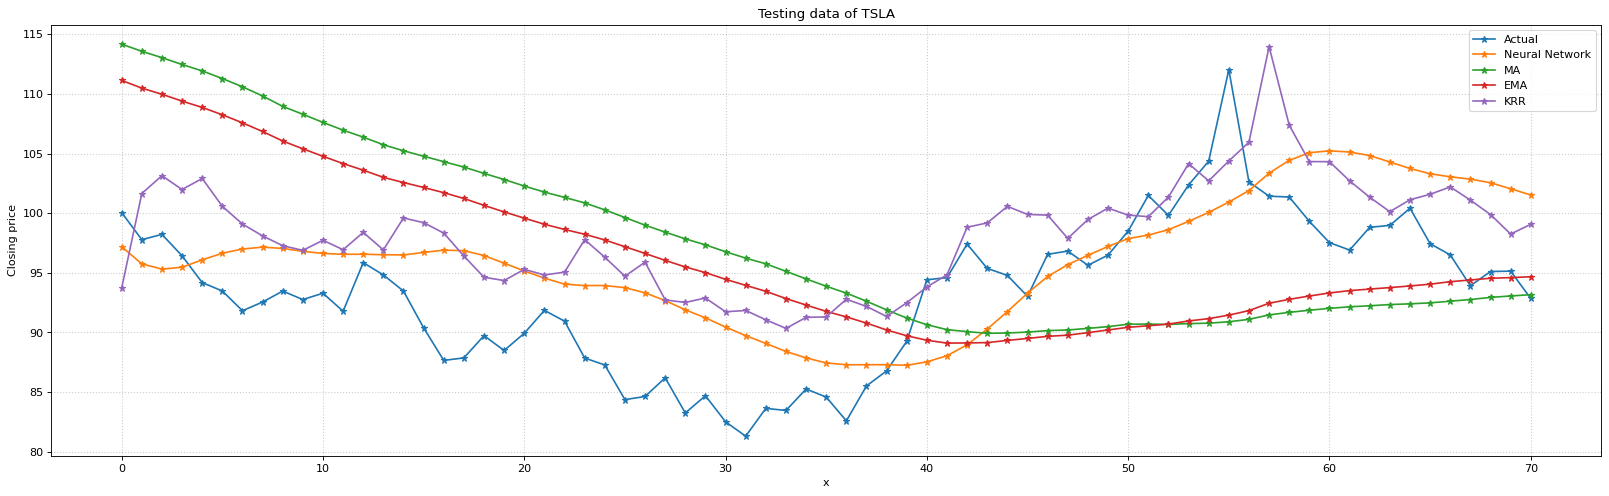

Training NN  Validation NN  Testing NN  Testing KRR  Testing MA  \
MSE     47.508294     110.007219   29.531121    37.968501  131.299272   
RMSE     6.892626      10.488433    5.434254     6.161859   11.458589   
MAPE     3.484255       7.764645    5.102725     5.979233   11.239135   
DA       0.491103       0.521739    0.485714     0.500000    0.528571   
R²       0.866464       0.496209    0.223879     0.002133   -2.450736   

      Testing EMA  
MSE     93.997416  
RMSE     9.695226  
MAPE     9.482228  
DA       0.514286  
R²      -1.470389

In [123]:
# Mean Squared Error
calc_mse = lambda y_true, y_pred: np.mean((y_true-y_pred)**2)
# Root Mean Squared Error
calc_rmse = lambda y_true, y_pred: np.sqrt(np.mean((y_true-y_pred)**2))
# Mean Absolute Error
calc_mae = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))
# Mean Absolute Percentage Error
calc_mape = lambda y_true, y_pred: np.mean(np.abs((y_true-y_pred) / y_true))*100
# Directional accuracy
calc_da = lambda y_true, y_pred: np.mean([(y_true[i+1]-y_true[i])*(y_pred[i+1]-y_pred[i]) > 0 for i in range(len(y_true)-1)])
# Coefficient of determination R²
calc_cod = lambda y_true, y_pred: 1 - (sum((y_true - y_pred)**2) / sum((y_true - np.mean(y_true))**2))

# get results from all the trained networks
for key, net in trained_nets.items():
    model = net
    data = datasets[key[1]]
    # for the training
    pred_ytrain = model.predict(data["xtrain"])
    ytrain = data["ytrain"]
    # scaler = config["data"]["scaler"]
    pred_ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytrain))
    ytrain = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytrain, axis=0)))

    # for the training
    pred_yval = model.predict(data["xval"])
    yval = data["yval"]
    # scaler = config["data"]["scaler"]
    pred_yval = np.squeeze(config["data"]["scaler"].inverse_transform(pred_yval))
    yval = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(yval, axis=0)))

    # for the training
    pred_ytest = model.predict(data["xtest"])
    ytest = data["ytest"]
    # scaler = config["data"]["scaler"]
    pred_ytest = np.squeeze(config["data"]["scaler"].inverse_transform(pred_ytest))
    ytest = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(ytest, axis=0)))
    # ALL 3 TOGETHER
    # plot the results
    fig= plt.figure(figsize=(25, 7), dpi=80)
    # for the training
    plt.plot(data["trainDates"],ytrain) # train data
    plt.plot(data["trainDates"], pred_ytrain)
    plt.plot(data["valDates"], yval) # val data
    plt.plot(data["valDates"], pred_yval)
    plt.plot(data["testDates"], ytest) # test data
    plt.plot(data["testDates"], pred_ytest)
    plt.title(f"ALL DATA of {key}")
    plt.xlabel("x")
    plt.ylabel("Closing price")
    plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
    plt.show()

    # Kernel Ridge Regression
    from sklearn.kernel_ridge import KernelRidge
    krr = KernelRidge(alpha=0.1, kernel='rbf') # why is rbf been used here? and what does the alpha control
    # Train the model on the training data
    krr.fit(data['xtrain'][:, -1, :], data['ytrain'])
    # Make predictions on the test data
    pred_krr = krr.predict(data['xtest'][:, -1, :])
    pred_krr = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_krr, axis=0)))


    # calcualte the price using a simple moving average
    pred_ma = np.mean(data["xtest"], axis = 1)
    pred_ma = pred_ma[:, 0] # take only the adjclose price out
    pred_ma = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ma, axis=0)))

    # calculate the price using exponential moving average
    pred_ema = data["xtest"][:, :, 0] # only take the 
    # pred_EMA = np.squeeze(config["data"]["scaler"].inverse_transform(pred_EMA))
    weights = np.exp(np.linspace(-1, 0, key[0][0]))
    weights /= weights.sum()
    pred_ema = pred_ema@weights
    pred_ema = np.squeeze(config["data"]["scaler"].inverse_transform(np.expand_dims(pred_ema, axis=0)))

    # plot the results
    fig= plt.figure(figsize=(25, 7), dpi=80)
    plt.plot(ytest, "*-") # actual data
    plt.plot(pred_ytest, "*-") # prediction made by neural network
    plt.plot(pred_ma, "*-")
    plt.plot(pred_ema, "*-")
    plt.plot(pred_krr, "*-")
    plt.title(f"Testing data of {config['data']['ticker']}")
    plt.xlabel("x")
    plt.ylabel("Closing price")
    xticks = 100
    step = round(len(data["raw"]["adjclose"].keys())/xticks)
    plt.grid(which="major", color='k', linestyle=':', linewidth=1, alpha = 0.2)
    plt.legend("Actual,Neural Network,MA,EMA,KRR".split(","))
    plt.show()

    # compare all the following data
    pairs = [[ytrain, pred_ytrain, 'Training NN'],
            [yval, pred_yval, 'Validation NN'],
            [ytest, pred_ytest, 'Testing NN'],
            [ytest, pred_krr, 'Testing KRR'],
            [ytest, pred_ma, 'Testing MA'],
            [ytest, pred_ema, 'Testing EMA']
            ]
    d = {}
    for pair in pairs:
        d[pair[2]] = []
        d[pair[2]].append(calc_mse(pair[0], pair[1]))
        d[pair[2]].append(calc_rmse(pair[0], pair[1]))
        # d[pair[2]].append(calc_mae(pair[0], pair[1]))
        d[pair[2]].append(calc_mape(pair[0], pair[1]))
        d[pair[2]].append(calc_da(pair[0], pair[1]))
        d[pair[2]].append(calc_cod(pair[0], pair[1]))

    df = pd.DataFrame(data=d)
    df.index = ['MSE', 'RMSE', 'MAPE', 'DA', 'R²']
    display(df)